<a href="https://colab.research.google.com/github/fatusilva/test/blob/master/TFM_CSAT_FatimaSilva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Fin de Máster (TFM)
## Predicción de la satisfacción del cliente (CSAT) en un Contact Center
---


In [1]:
!pip -q install xgboost imbalanced-learn

!wget https://github.com/fatusilva/test/raw/master/BaseEncuestasClientes.xlsx -O archivo.xlsx

--2025-09-17 11:29:01--  https://github.com/fatusilva/test/raw/master/BaseEncuestasClientes.xlsx
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fatusilva/test/master/BaseEncuestasClientes.xlsx [following]
--2025-09-17 11:29:02--  https://raw.githubusercontent.com/fatusilva/test/master/BaseEncuestasClientes.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17571272 (17M) [application/octet-stream]
Saving to: ‘archivo.xlsx’

archivo.xlsx        100%[===================>]  16.76M  86.1MB/s    in 0.2s    

2025-09-17 11:29:02 (86.1 MB/s) - ‘archivo.xlsx’ saved [17571272/17571272]



In [1]:
import numpy as np, json
import pandas as pd
import re
from datetime import datetime
#from google.colab import files

# Modelado / Métricas
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,make_scorer, f1_score, recall_score,precision_score

# Opcional (plots)
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost
from xgboost import XGBClassifier
import xgboost as xgb

pd.set_option('display.max_colwidth', 120)
pd.set_option('display.max_columns', 200)


In [2]:

#uploaded = files.upload()  # subí tu .xlsx
#FILE_PATH = list(uploaded.keys())[0]
#SHEET_NAME = None  # o el nombre de la hoja si querés especificar

# --- Carga de la base ---
FILE_PATH = "https://github.com/fatusilva/test/raw/master/BaseEncuestasClientes.xlsx"
SHEET_NAME = None  # o el nombre de la hoja si querés especificar

# Ver qué hojas tiene el archivo
xl = pd.ExcelFile(FILE_PATH)
print("Hojas encontradas:", xl.sheet_names)

# Cargar la hoja (si SHEET_NAME es None usa la primera)
df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME or 0, header=1)

# Normalizar nombres
df.columns = [str(c).strip() for c in df.columns]

print("Shape inicial:", df.shape)
print("Primeras columnas:", df.columns[:10].tolist())
df.head()



Hojas encontradas: ['Sheet0']
Shape inicial: (38005, 104)
Primeras columnas: ['Fecha de inicio', 'Fecha de finalización', 'Progreso', 'Duración (en segundos)', 'Finalizado', 'Fecha registrada', 'ID de respuesta', 'Apellido del destinatario', 'Nombre del destinatario', 'Referencia a datos externos']


,Fecha de inicio,Fecha de finalización,Progreso,Duración (en segundos),Finalizado,Fecha registrada,ID de respuesta,Apellido del destinatario,Nombre del destinatario,Referencia a datos externos,Latitud de la ubicación,Longitud de la ubicación,Canal de la distribución,Idioma del usuario,¿Resolvimos tu consulta?,¿Cómo calificas tu experiencia en la sucursal?,¿Cómo calificas el tiempo de espera en la sucursal?,¿Cómo calificas la organización de la sucursal para atender tu consulta?,¿Cómo calificas la comodidad de las instalaciones en la sucursal?,¿Cómo calificás la atención recibida por nuestro ejecutivo/a en la sucursal?,¿Cómo calificás la atención recibida por nuestro equipo de experiencia?,¿Algo más que nos quieras compartir?,genero,rango_etario,cluster,ciudad,cuenta_creada,tarjeta_fisica_credito,ultimo_movimiento_tc,tarjeta_fisica_debito,oferta_preaprobada_activa_prestamo,prestamo_activo,ultimo_movimiento_qr,ultima_transferencia,contrato_unico_firmado,ultimo_pago_servicios,tarjeta_duocard,oferta_preaprobada_activa_tc,derivacion_caso,grupo_producto,motivo_contacto,motivo_reclamo,resolucion_favor_cliente,ticket_id,tiempo_resolucion,ya_es_cliente,agente_asignado_vinanzas,agente_asignado_operaciones,persona_asignada,sent_date,canal_de_transacción,departamento,cliente_origen,bandeja,canal_ticket,Formulario CSAT,Etiquetas,agente_asignado,Estado,CaseNumber_sf,Id_sf,Origin_sf,Reason_sf,Executive_sf,sourceObject_sf,sucursal_sf,Producto_sf,Prioridad_sf,Descripcion_sf,Type_sf,Timeescalated_sf,Subproduct_sf,ROTDerivation_sf,ejecutivo_email_sf,fecha_creacion_caso_sf,fecha_cierre_caso_sf,Recontacto_sf,segmento,SurveyID,recordType,CSAT Atención Digital N,CSAT Atención Sucursal N,CSAT Comodidad Suc N,CSAT General,CSAT Organización Suc N,CSAT Sucursal N,CSAT Tiempo Suc N,Q3 - Actionability,Q3 - Effort,Q3 - Effort Numeric,Q3 - Emotion Intensity,Q3 - Emotion,Q3 - Parent Topics,Q3 - Sentiment Polarity,Q3 - Sentiment Score,Q3 - Sentiment,Q3 - Topic Sentiment Label,Q3 - Topic Sentiment Score,Q3 - Topics,Producto_type_sf,Regiones,Tipo de Atención,Regiones_sf,Q3 - Topic Hierarchy Level 1
0,2024-12-31 22:39:41,2024-12-31 22:40:06,100,25,True,2024-12-31 22:40:07.404,R_3q5vTMtZYmzSu3v,ALSINA,MARIA,NaN,-23.3333,-58.0000,email,ES,Sí,NaN,NaN,NaN,NaN,NaN,5 Muy Buena,Gracias por la ayuda brindada! Feliz año nuevo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deriva_a_sin_derivación,NaN,NaN,NaN,NaN,3685286.0,NaN,ya_es_cliente,NaN,NaN,Enzo Florentin,NaN,NaN,NaN,NaN,redes_sociales_c,NaN,formulario_digital,buenas ci_actualizado consulta cuenta deriva_a_sin_derivación desvio_automatico email_cst formulario_digital motivo_...,NaN,Cerrado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SV_e96vbeWvrEmvs10,Satisfaccion_y_resolucion_de_caso,5.0,NaN,NaN,5.0,NaN,NaN,NaN,other,Easy,1.0,Medium,Thankfulness,NaN,0.0,1.0,Positive,NaN,NaN,Unknown,NaN,Sin categoría,Digital y Telefónico,NaN,NaN
1,2024-12-31 23:00:38,2024-12-31 23:00:48,100,9,True,2024-12-31 23:00:48.963,R_3EuIo9OuYEyUwhk,LEGUIZAMON,MARIO,NaN,-25.2869,-57.6511,email,ES,Sí,NaN,NaN,NaN,NaN,NaN,5 Muy Buena,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,redes_sociales_,tarjetas__,NaN,NaN,NaN,3684772.0,NaN,ya_es_cliente,NaN,NaN,Gerson Rodas,NaN,canal_tx_no_aplica,NaN,NaN,redes_sociales_c,NaN,formulario_digital,_no_ canal_tx_no_aplica casuisticas_loyalty_beneficios_reintegro_historial_de_reintegro chatinapp ci_actualizado con...,NaN,Cerrado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SV_e96vbeWvrEmvs10,Satisfaccion_y_resolucion_de_caso,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sin categoría,Digital y Telefónico,NaN,NaN
2,2024-12-31 23:06:09,2024-12-31 23:06:47,100,37,True,2024-12-31 23:06:47.916,R_3kyS43P8QCgHTS1,ESCOBAR,ALMA,NaN,-25.2869,-57.6511,email,ES,Sí,NaN,NaN,NaN,NaN,NaN,5 Muy Buena,Feliz Año 2025!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,segunda_linea,

In [4]:
# Detectar y convertir columnas de fechas si existen
posibles_fecha_encuesta = ['Fecha registrada', 'Fecha Registrada']
fecha_encuesta_col = next((c for c in posibles_fecha_encuesta if c in df.columns), None)

if fecha_encuesta_col:
    df[fecha_encuesta_col] = pd.to_datetime(df[fecha_encuesta_col], errors='coerce')

# cuenta_creada (alta del cliente)
if 'cuenta_creada' in df.columns:
    df['cuenta_creada'] = pd.to_datetime(df['cuenta_creada'], errors='coerce')

# Antigüedad del cliente en meses (aprox; días/30.44)
if fecha_encuesta_col and 'cuenta_creada' in df.columns:
    diff_days = (df[fecha_encuesta_col] - df['cuenta_creada']).dt.days
    df['antiguedad_cliente_meses'] = (diff_days / 30.44).clip(lower=0)
else:
    df['antiguedad_cliente_meses'] = np.nan


# Crear rangos de antigüedad
bins = [0, 6, 12, 24, 60, 120, float('inf')]
labels = ['<6m', '6-12m', '1-2a', '2-5a', '5-10a', '10+a']
df['antiguedad_rango'] = pd.cut(df['antiguedad_cliente_meses'], bins=bins, labels=labels)


# Derivados temporales (si hay fecha de encuesta)
if fecha_encuesta_col:
    df['mes_encuesta'] = df[fecha_encuesta_col].dt.month
    df['dia_semana_encuesta'] = df[fecha_encuesta_col].dt.weekday
    df['hora_encuesta'] = df[fecha_encuesta_col].dt.hour

print("Shape inicial:", df.shape)
print("Primeras columnas:", df.columns[:50].tolist())
df.head()

Shape inicial: (38005, 109)
Primeras columnas: ['Fecha de inicio', 'Fecha de finalización', 'Progreso', 'Duración (en segundos)', 'Finalizado', 'Fecha registrada', 'ID de respuesta', 'Apellido del destinatario', 'Nombre del destinatario', 'Referencia a datos externos', 'Latitud de la ubicación', 'Longitud de la ubicación', 'Canal de la distribución', 'Idioma del usuario', '¿Resolvimos tu consulta?', '¿Cómo calificas tu experiencia en la sucursal?', '¿Cómo calificas el tiempo de espera en la sucursal?', '¿Cómo calificas la organización de la sucursal para atender tu consulta?', '¿Cómo calificas la comodidad de las instalaciones en la sucursal?', '¿Cómo calificás la atención recibida por nuestro ejecutivo/a en la sucursal?', '¿Cómo calificás la atención recibida por nuestro equipo de experiencia?', '¿Algo más que nos quieras compartir?', 'genero', 'rango_etario', 'cluster', 'ciudad', 'cuenta_creada', 'tarjeta_fisica_credito', 'ultimo_movimiento_tc', 'tarjeta_fisica_debito', 'oferta_preap

,Fecha de inicio,Fecha de finalización,Progreso,Duración (en segundos),Finalizado,Fecha registrada,ID de respuesta,Apellido del destinatario,Nombre del destinatario,Referencia a datos externos,Latitud de la ubicación,Longitud de la ubicación,Canal de la distribución,Idioma del usuario,¿Resolvimos tu consulta?,¿Cómo calificas tu experiencia en la sucursal?,¿Cómo calificas el tiempo de espera en la sucursal?,¿Cómo calificas la organización de la sucursal para atender tu consulta?,¿Cómo calificas la comodidad de las instalaciones en la sucursal?,¿Cómo calificás la atención recibida por nuestro ejecutivo/a en la sucursal?,¿Cómo calificás la atención recibida por nuestro equipo de experiencia?,¿Algo más que nos quieras compartir?,genero,rango_etario,cluster,ciudad,cuenta_creada,tarjeta_fisica_credito,ultimo_movimiento_tc,tarjeta_fisica_debito,oferta_preaprobada_activa_prestamo,prestamo_activo,ultimo_movimiento_qr,ultima_transferencia,contrato_unico_firmado,ultimo_pago_servicios,tarjeta_duocard,oferta_preaprobada_activa_tc,derivacion_caso,grupo_producto,motivo_contacto,motivo_reclamo,resolucion_favor_cliente,ticket_id,tiempo_resolucion,ya_es_cliente,agente_asignado_vinanzas,agente_asignado_operaciones,persona_asignada,sent_date,canal_de_transacción,departamento,cliente_origen,bandeja,canal_ticket,Formulario CSAT,Etiquetas,agente_asignado,Estado,CaseNumber_sf,Id_sf,Origin_sf,Reason_sf,Executive_sf,sourceObject_sf,sucursal_sf,Producto_sf,Prioridad_sf,Descripcion_sf,Type_sf,Timeescalated_sf,Subproduct_sf,ROTDerivation_sf,ejecutivo_email_sf,fecha_creacion_caso_sf,fecha_cierre_caso_sf,Recontacto_sf,segmento,SurveyID,recordType,CSAT Atención Digital N,CSAT Atención Sucursal N,CSAT Comodidad Suc N,CSAT General,CSAT Organización Suc N,CSAT Sucursal N,CSAT Tiempo Suc N,Q3 - Actionability,Q3 - Effort,Q3 - Effort Numeric,Q3 - Emotion Intensity,Q3 - Emotion,Q3 - Parent Topics,Q3 - Sentiment Polarity,Q3 - Sentiment Score,Q3 - Sentiment,Q3 - Topic Sentiment Label,Q3 - Topic Sentiment Score,Q3 - Topics,Producto_type_sf,Regiones,Tipo de Atención,Regiones_sf,Q3 - Topic Hierarchy Level 1,antiguedad_cliente_meses,antiguedad_rango,mes_encuesta,dia_semana_encuesta,hora_encuesta
0,2024-12-31 22:39:41,2024-12-31 22:40:06,100,25,True,2024-12-31 22:40:07.404,R_3q5vTMtZYmzSu3v,ALSINA,MARIA,NaN,-23.3333,-58.0000,email,ES,Sí,NaN,NaN,NaN,NaN,NaN,5 Muy Buena,Gracias por la ayuda brindada! Feliz año nuevo,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deriva_a_sin_derivación,NaN,NaN,NaN,NaN,3685286.0,NaN,ya_es_cliente,NaN,NaN,Enzo Florentin,NaN,NaN,NaN,NaN,redes_sociales_c,NaN,formulario_digital,buenas ci_actualizado consulta cuenta deriva_a_sin_derivación desvio_automatico email_cst formulario_digital motivo_...,NaN,Cerrado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SV_e96vbeWvrEmvs10,Satisfaccion_y_resolucion_de_caso,5.0,NaN,NaN,5.0,NaN,NaN,NaN,other,Easy,1.0,Medium,Thankfulness,NaN,0.0,1.0,Positive,NaN,NaN,Unknown,NaN,Sin categoría,Digital y Telefónico,NaN,NaN,NaN,NaN,12,1,22
1,2024-12-31 23:00:38,2024-12-31 23:00:48,100,9,True,2024-12-31 23:00:48.963,R_3EuIo9OuYEyUwhk,LEGUIZAMON,MARIO,NaN,-25.2869,-57.6511,email,ES,Sí,NaN,NaN,NaN,NaN,NaN,5 Muy Buena,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,redes_sociales_,tarjetas__,NaN,NaN,NaN,3684772.0,NaN,ya_es_cliente,NaN,NaN,Gerson Rodas,NaN,canal_tx_no_aplica,NaN,NaN,redes_sociales_c,NaN,formulario_digital,_no_ canal_tx_no_aplica casuisticas_loyalty_beneficios_reintegro_historial_de_reintegro chatinapp ci_actualizado con...,NaN,Cerrado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SV_e96vbeWvrEmvs10,Satisfaccion_y_resolucion_de_caso,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sin categoría,Digital y Telefónico,NaN,NaN,NaN,NaN,12,1,23
2,2024-12-31 23:06:09,2024-12-31 23:06:47,100,37,True,2024-12-31 23:06:47.916,R_3kyS43P8QCgHTS1,ESCOBAR,ALMA,NaN,-25.2869,-57.6511,email,ES,Sí,NaN,N






# Exploración visual
*   CSAT promedio por rango de antigüedad:

In [5]:
# Asegurarse de que CSAT sea numérico
df['CSAT General'] = pd.to_numeric(df['CSAT General'], errors='coerce')


/tmp/ipython-input-232848053.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  csat_por_antig = df.groupby('antiguedad_rango')['CSAT General'].mean()


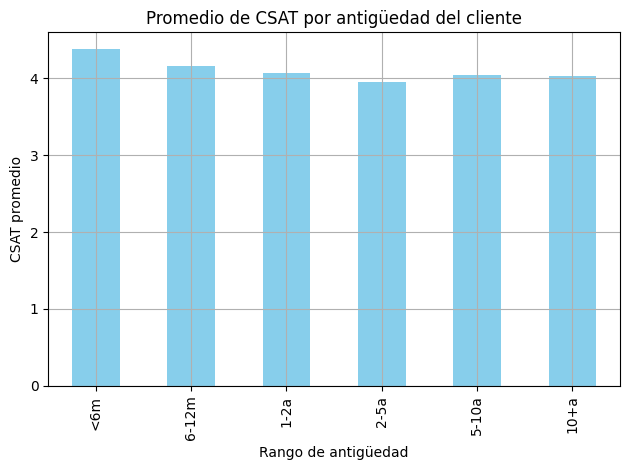

In [6]:
#Visualizar la distribucion del CSAT por diferentes variable

# Promedio de CSAT por rango
csat_por_antig = df.groupby('antiguedad_rango')['CSAT General'].mean()
csat_por_producto = df.groupby('grupo_producto')['CSAT General'].mean()
csat_por_producto = df.groupby('motivo_contacto')['CSAT General'].mean()

# Gráfico
csat_por_antig.plot(kind='bar', title='Promedio de CSAT por antigüedad del cliente', color='skyblue')
plt.ylabel('CSAT promedio')
plt.xlabel('Rango de antigüedad')
plt.grid(True)
plt.tight_layout()
plt.show()


Analisis de nulos

In [7]:
nulos = df.isnull().sum().to_frame(name='Cantidad de nulos')
nulos['% de nulos'] = (nulos['Cantidad de nulos'] / len(df) * 100).round(2)
nulos = nulos[nulos['Cantidad de nulos'] > 0].sort_values(by='% de nulos', ascending=False)
display(nulos.head(100))
df.isnull().sum()*100/df.shape[0]


,Cantidad de nulos,% de nulos
Descripcion_sf,38005,100.00
agente_asignado_vinanzas,38005,100.00
Q3 - Parent Topics,38005,100.00
agente_asignado,38005,100.00
agente_asignado_operaciones,38005,100.00
...,...,...
CSAT General,1128,2.97
Nombre del destinatario,1089,2.87
persona_asignada,668,1.76
Latitud de la ubicación,99,0.26


,0
Fecha de inicio,0.000000
Fecha de finalización,0.000000
Progreso,0.000000
Duración (en segundos),0.000000
Finalizado,0.000000
...,...
antiguedad_cliente_meses,10.240758
antiguedad_rango,10.240758
mes_encuesta,0.000000
dia_semana_encuesta,0.000000


In [8]:
# CSAT General -> binaria: 1 si CSAT >= 4, 0 en caso contrario
assert 'CSAT General' in df.columns, "No se encontró 'CSAT General' en el dataset."
df['CSAT_bin'] = (df['CSAT General'] >= 4).astype(int)

# ⚠️ Eliminar variables de fuga relacionadas a resolución (si están)
fuga_patterns = ['resoluc', 'Respuesta Resolucion','¿Resolvimos tu consulta?']
cols_fuga = [c for c in df.columns if any(pat.lower() in c.lower() for pat in fuga_patterns)]
df = df.drop(columns=cols_fuga, errors='ignore')

print("Columnas de fuga eliminadas:", cols_fuga)
print("Distribución CSAT_bin:\n", df['CSAT_bin'].value_counts(normalize=True).round(4)*100)


Columnas de fuga eliminadas: ['¿Resolvimos tu consulta?', 'resolucion_favor_cliente', 'tiempo_resolucion']
Distribución CSAT_bin:
 CSAT_bin
1    72.76
0    27.24
Name: proportion, dtype: float64


In [9]:
# Elegir columna origen
posibles_motivo = ['motivo_contacto']
motivo_col = next((c for c in posibles_motivo if c in df.columns), None)

def agrupar_motivos_texto(valor):
    if pd.isna(valor):
        return 'Otro'
    v = str(valor).lower()
    # Tarjeta
    if any(k in v for k in ['tarjeta', 'plástico', 'pin', 'visa', 'mastercard', 'extravio', 'bloqueo']):
        return 'Tarjeta'
    # Préstamos / créditos
    if any(k in v for k in ['préstam', 'prestam', 'cuota', 'sobregiro', 'credito', 'crédito']):
        return 'Préstamos'
    # Transferencias / pagos / QR / billeteras / ATM
    if any(k in v for k in ['transferen', 'pago', 'qr', 'ted', 'atm', 'alias', 'debito', 'débito', 'swift', 'cnb']):
        return 'Transferencias/ Pagos'
    # Cuenta / App / Acceso / Onboarding
    if any(k in v for k in ['cuenta', 'onboarding', 'contraseña', 'password', 'app', 'login', 'web', 'canal']):
        return 'Cuenta/App'
    # Ofertas / Comercial / Promos
    if any(k in v for k in ['oferta', 'promoc', 'comercial', 'venta', 'promo','loyal']):
        return 'Ofertas/Comercial'
    # Fraude / seguridad
    if any(k in v for k in ['fraude', 'estafa', 'seguridad', 'vulneración', 'robo']):
        return 'Fraude/Seguridad'
    # Inversiones / CDA / fondos / casa de bolsa
    if any(k in v for k in ['cda', 'fondo', 'invers', 'bolsa']):
        return 'Inversiones'
    # Servicios / facturas
    if any(k in v for k in ['servicio', 'factura', 'facturador']):
        return 'Servicios'
    # Generales / Operativos
    if any(k in v for k in ['consulta', 'requisito', 'condicion', 'soporte', 'ayuda', 'informacion', 'información']):
        return 'Operativo/Soporte'
    return 'Otro'

if motivo_col:
    if df[motivo_col].dtype == object:
        df['motivo_contacto_categoria'] = df[motivo_col].apply(agrupar_motivos_texto)
    else:
        # Si no tenés el texto original, vas a agrupar a 'Otro'
        df['motivo_contacto_categoria'] = 'Otro'
else:
    df['motivo_contacto_categoria'] = 'Otro'

df['motivo_contacto_categoria'] = df['motivo_contacto_categoria'].fillna('Otro')

print("Top categorías motivo_contacto_categoria:")
print(df['motivo_contacto_categoria'].value_counts().head(10))


Top categorías motivo_contacto_categoria:
motivo_contacto_categoria
Otro                     16542
Tarjeta                   6480
Ofertas/Comercial         3730
Transferencias/ Pagos     3703
Cuenta/App                3084
Préstamos                 2248
Operativo/Soporte         1409
Servicios                  622
Fraude/Seguridad           111
Inversiones                 76
Name: count, dtype: int64


In [10]:
for name in ['X','y','X_train','X_test','y_train','y_test','X_train_scaled','X_test_scaled']:
    if name in globals():
        del globals()[name]

In [11]:
# 1) Lista blanca de columnas (ajustá nombres según existan en tu df)
whitelist = [
    # Cliente / perfil
    'antiguedad_cliente_meses','rango_etario','genero','ya_es_cliente','Recontacto_sf',
    # Canal / flujo
    #'canal_ticket','Canal','canal_de_transacción','Tipo de Atención','tipo_registro_caso','bandeja','Area','departamento',
    # Producto / motivo
        #'grupo_producto',
    'Producto_sf','Subproduct_sf','motivo_contacto_categoria'
    # Tiempo / operación
    #'Duración (en segundos)','mes_encuesta','dia_semana_encuesta','hora_encuesta'
]

# 2) Construir df_modelo solo con whitelist + target
cols_existentes = [c for c in whitelist if c in df.columns]
df_modelo = df[cols_existentes + ['CSAT_bin']].copy()

print("✅ Columnas usadas:", df_modelo.columns.tolist())

# 3) (doble seguro) No permitir CSAT* ni Resolucion* en features
ban_patterns = ['csat', 'satisf', 'resoluc']
cols_ban = [c for c in df_modelo.columns if any(p in c.lower() for p in ban_patterns) and c != 'CSAT_bin']
if cols_ban:
    df_modelo = df_modelo.drop(columns=cols_ban)
    print("🚫 Quitadas por seguridad:", cols_ban)




✅ Columnas usadas: ['antiguedad_cliente_meses', 'rango_etario', 'genero', 'ya_es_cliente', 'Recontacto_sf', 'Producto_sf', 'Subproduct_sf', 'motivo_contacto_categoria', 'CSAT_bin']


In [12]:
# 4) Separar X/y
X = df_modelo.drop(columns=['CSAT_bin']).copy()
y = df_modelo['CSAT_bin'].astype(int)

# 5) Codificar solo las categóricas que queden en X
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
print("🔤 Categóricas codificadas:", cat_cols)

# 6) Imputación (por si queda algún NaN)
imp = SimpleImputer(strategy='mean')
X = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

# 7) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


print("✅ X_train:", X_train.shape, "y_train:", y_train.shape)
print("✅ X_test:", X_test.shape, "y_test:", y_test.shape)

print("📊 y_train %:\n", (y_train.value_counts(normalize=True)*100).round(2))


resumen = pd.DataFrame({
    'Variable': X.columns,
    'dtype': X.dtypes.values,
    '% nulos': (X.isnull().mean()*100).round(2),
    'n_únicos': [X[c].nunique() for c in X.columns]
}).sort_values('% nulos', ascending=False)
resumen.head(20)

🔤 Categóricas codificadas: ['rango_etario', 'genero', 'ya_es_cliente', 'Recontacto_sf', 'Producto_sf', 'Subproduct_sf', 'motivo_contacto_categoria']
✅ X_train: (30404, 8) y_train: (30404,)
✅ X_test: (7601, 8) y_test: (7601,)
📊 y_train %:
 CSAT_bin
1    72.76
0    27.24
Name: proportion, dtype: float64


,Variable,dtype,% nulos,n_únicos
antiguedad_cliente_meses,antiguedad_cliente_meses,float64,0.0,4819
rango_etario,rango_etario,float64,0.0,8
genero,genero,float64,0.0,3
ya_es_cliente,ya_es_cliente,float64,0.0,5
Recontacto_sf,Recontacto_sf,float64,0.0,3
Producto_sf,Producto_sf,float64,0.0,56
Subproduct_sf,Subproduct_sf,float64,0.0,112
motivo_contacto_categoria,motivo_contacto_categoria,float64,0.0,10


from matplotlib import pyplot as plt
_df_0['n_únicos'].plot(kind='hist', bins=20, title='n_únicos')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Variable').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['% nulos']
  ys = series['n_únicos']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('% nulos', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Variable')):
  _plot_series(series, series_name, i)
  fig.legend(title='Variable', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('% nulos')
_ = plt.ylabel('n_únicos')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['% nulos']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': '% nulos'}, axis=1)
              .sort_values('% nulos', ascending=True))
  xs = counted['% nulos']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('% nulos', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Variable')):
  _plot_series(series, series_name, i)
  fig.legend(title='Variable', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('% nulos')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_4['n_únicos'].plot(kind='line', figsize=(8, 4), title='n_únicos')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['Variable'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='n_únicos', y='Variable', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [13]:
print("✅ Columnas usadas:", df_modelo.columns.tolist())

# Análisis de valores nulos
nulos = df_modelo.isnull().sum().to_frame(name='Cantidad de nulos')
nulos['% de nulos'] = (nulos['Cantidad de nulos'] / len(df) * 100).round(2)
nulos = nulos[nulos['Cantidad de nulos'] > 0].sort_values(by='% de nulos', ascending=False)
nulos.head(20)

print("🔧 Features usadas por el modelo:", X.columns.tolist())
print("Shape X:", X.shape, " | Shape y:", y.shape)
print("\nTipos de datos:")
print(X.dtypes.value_counts())

✅ Columnas usadas: ['antiguedad_cliente_meses', 'rango_etario', 'genero', 'ya_es_cliente', 'Recontacto_sf', 'Producto_sf', 'Subproduct_sf', 'motivo_contacto_categoria', 'CSAT_bin']
🔧 Features usadas por el modelo: ['antiguedad_cliente_meses', 'rango_etario', 'genero', 'ya_es_cliente', 'Recontacto_sf', 'Producto_sf', 'Subproduct_sf', 'motivo_contacto_categoria']
Shape X: (38005, 8)  | Shape y: (38005,)

Tipos de datos:
float64    8
Name: count, dtype: int64


In [14]:
# Eliminar columnas con 100% NaNs
columnas_100_nan = X_train.columns[X_train.isnull().all()]
print("🧼 Columnas eliminadas por tener 100% NaNs:", columnas_100_nan.tolist())

X_train = X_train.drop(columns=columnas_100_nan)
X_test = X_test.drop(columns=columnas_100_nan, errors='ignore')

🧼 Columnas eliminadas por tener 100% NaNs: []


📌 Clasification Report — Regresión Logística (sin resolución):
              precision    recall  f1-score   support

           0       0.60      0.01      0.03      2071
           1       0.73      1.00      0.84      5530

    accuracy                           0.73      7601
   macro avg       0.67      0.51      0.43      7601
weighted avg       0.70      0.73      0.62      7601

📈 ROC-AUC: 0.6242961660334787
--


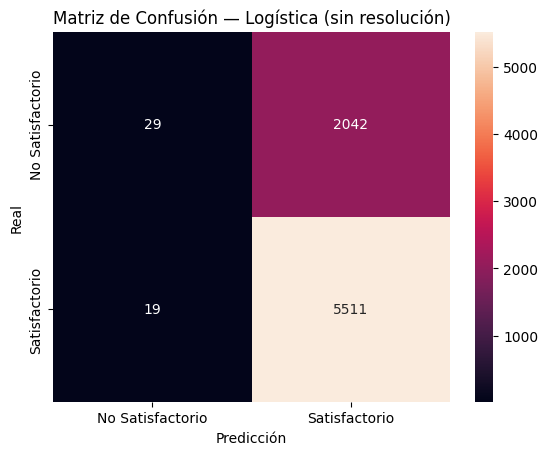

In [57]:
#Paso: Entrenamiento y evaluación de modelo base
#Usaremos:
#Regresión logística (simple y fácil de interpretar)
#Métricas: accuracy, precision, recall, f1_score, roc_auc
#Matriz de confusión

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

modelo_log = LogisticRegression(max_iter=8000)
modelo_log.fit(X_train_scaled, y_train)

y_pred_log = modelo_log.predict(X_test_scaled)
y_proba_log = modelo_log.predict_proba(X_test_scaled)[:, 1]

print("📌 Clasification Report — Regresión Logística (sin resolución):")
print(classification_report(y_test, y_pred_log))
print("📈 ROC-AUC:", roc_auc_score(y_test, y_proba_log))
print("--")
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No Satisfactorio', 'Satisfactorio'], yticklabels=['No Satisfactorio', 'Satisfactorio'])
plt.title("Matriz de Confusión — Logística (sin resolución)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


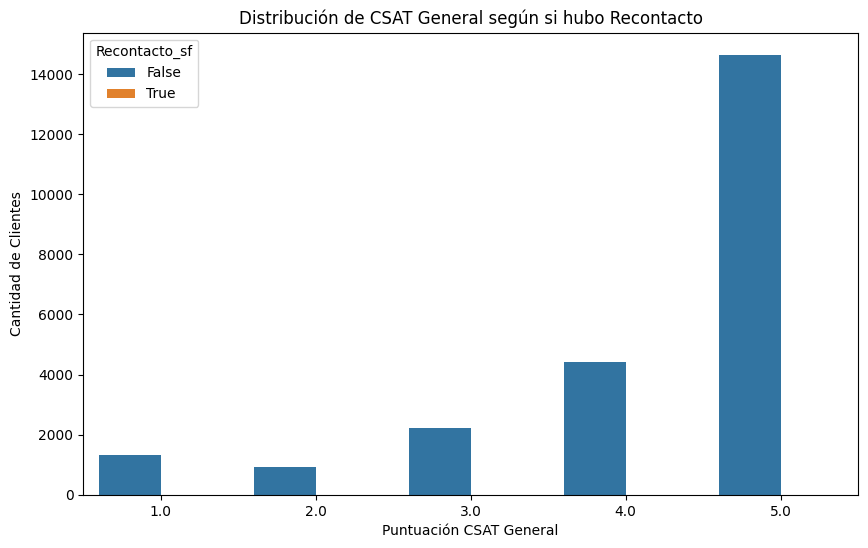

In [16]:
# Gráfico para visualizar la relación entre Recontacto y CSAT
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='CSAT General', hue='Recontacto_sf')
plt.title('Distribución de CSAT General según si hubo Recontacto')
plt.xlabel('Puntuación CSAT General')
plt.ylabel('Cantidad de Clientes')
plt.show()

                    Variable  Coeficiente
1               rango_etario     0.254457
6              Subproduct_sf     0.120371
5                Producto_sf     0.022454
7  motivo_contacto_categoria     0.010729
2                     genero    -0.065874
0   antiguedad_cliente_meses    -0.103128
3              ya_es_cliente    -0.137862
4              Recontacto_sf    -0.405800


/tmp/ipython-input-788399275.py:22: UserWarning: Glyph 128316 (\N{UP-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128316 (\N{UP-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


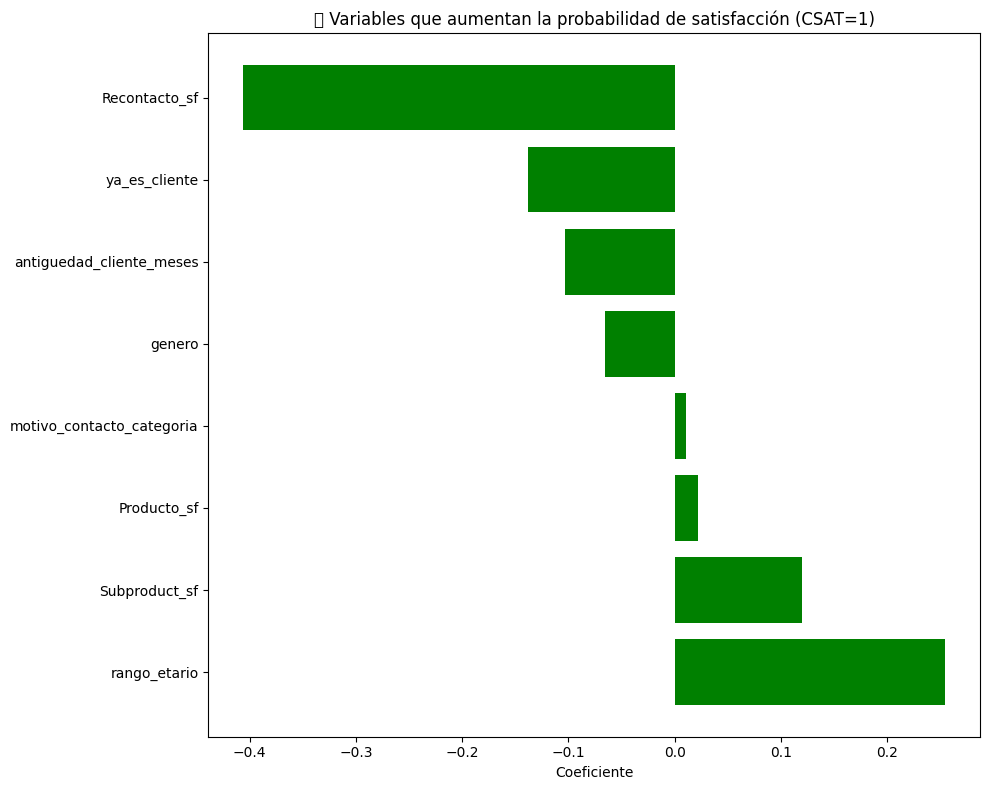

                    Variable  Coeficiente
1               rango_etario     0.254457
6              Subproduct_sf     0.120371
5                Producto_sf     0.022454
7  motivo_contacto_categoria     0.010729
2                     genero    -0.065874
0   antiguedad_cliente_meses    -0.103128
3              ya_es_cliente    -0.137862
4              Recontacto_sf    -0.405800


/tmp/ipython-input-788399275.py:32: UserWarning: Glyph 128317 (\N{DOWN-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128317 (\N{DOWN-POINTING SMALL RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


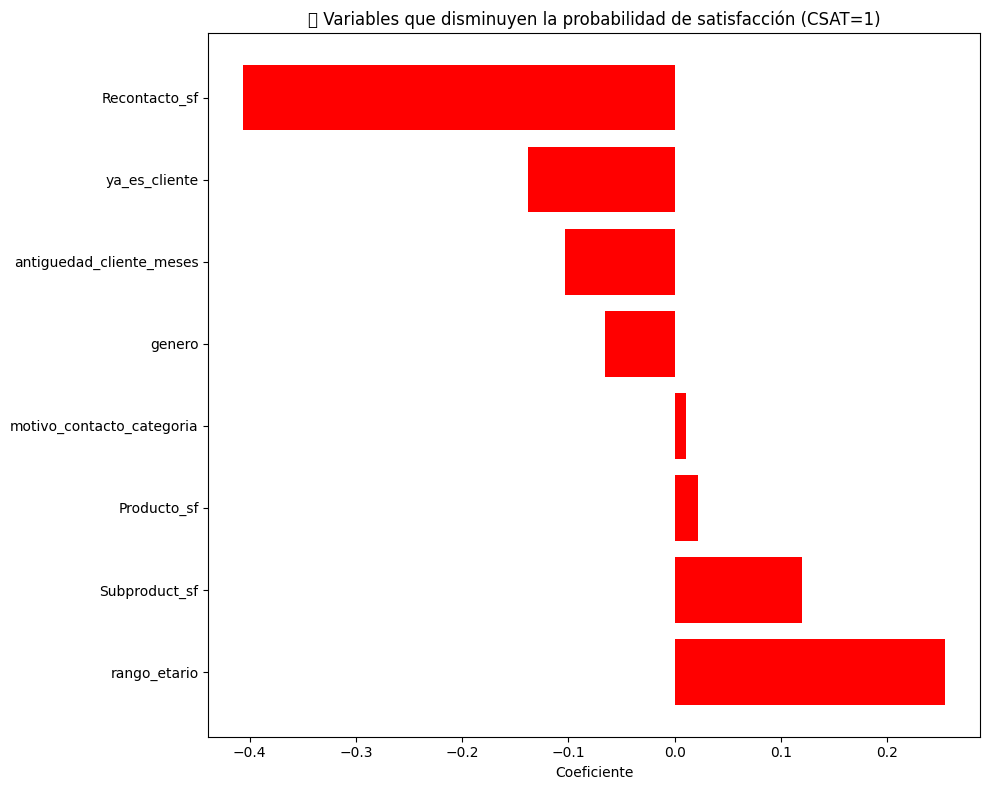

In [17]:
#Extraer el coeficiente
coeficientes = modelo_log.coef_[0]
variables = X_train.columns

#Crear dataframe
df_coef = pd.DataFrame({
    'Variable': variables,
    'Coeficiente': coeficientes
}).sort_values(by='Coeficiente', ascending=False)

# 🔝 Mostrar top 15 positivos y negativos
top_pos = df_coef.head(15)
top_neg = df_coef.tail(15)

print(top_pos)

# 📊 Gráfico de barras
plt.figure(figsize=(10, 8))
plt.barh(top_pos['Variable'], top_pos['Coeficiente'], color='green')
plt.title("🔼 Variables que aumentan la probabilidad de satisfacción (CSAT=1)")
plt.xlabel("Coeficiente")
plt.tight_layout()
plt.show()


print(top_pos)

plt.figure(figsize=(10, 8))
plt.barh(top_neg['Variable'], top_neg['Coeficiente'], color='red')
plt.title("🔽 Variables que disminuyen la probabilidad de satisfacción (CSAT=1)")
plt.xlabel("Coeficiente")
plt.tight_layout()
plt.show()

📌 Clasification Report — Random Forest (sin resolución):
              precision    recall  f1-score   support

           0       0.41      0.30      0.35      2071
           1       0.76      0.84      0.80      5530

    accuracy                           0.69      7601
   macro avg       0.59      0.57      0.57      7601
weighted avg       0.67      0.69      0.68      7601

📈 ROC-AUC: 0.6457162241336707
----


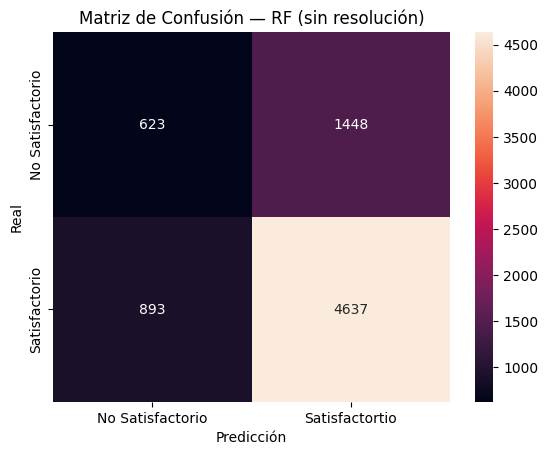

In [58]:
modelo_rf = RandomForestClassifier(n_estimators=200, random_state=42)
modelo_rf.fit(X_train, y_train)

y_pred_rf = modelo_rf.predict(X_test)
y_proba_rf = modelo_rf.predict_proba(X_test)[:, 1]

print("📌 Clasification Report — Random Forest (sin resolución):")
print(classification_report(y_test, y_pred_rf))
print("📈 ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("----")

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No Satisfactorio', 'Satisfactortio'], yticklabels=['No Satisfactorio', 'Satisfactorio'])
plt.title("Matriz de Confusión — RF (sin resolución)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


In [19]:
#modelo_xgb = XGBClassifier(
#    n_estimators=300,
#    max_depth=5,
#    learning_rate=0.1,
#    subsample=0.8,
#    colsample_bytree=0.8,
#    eval_metric='logloss',
#    random_state=42
#)
#modelo_xgb.fit(X_train, y_train)

#y_pred_xgb = modelo_xgb.predict(X_test)
#y_proba_xgb = modelo_xgb.predict_proba(X_test)[:, 1]

#print("📌 Clasification Report — XGBoost (sin resolución):")
#print(classification_report(y_test, y_pred_xgb))
#print("📈 ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

#cm = confusion_matrix(y_test, y_pred_xgb)
#sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No Sat', 'Sat'], yticklabels=['No Sat', 'Sat'])
#plt.title("Matriz de Confusión — XGBoost (sin resolución)")
#plt.xlabel("Predicción")
#plt.ylabel("Real")
#plt.show()


# **XGBoost con pesos + early stopping**

XGBoost version: 3.0.5
Mejor iteración: 692 | Mejor logloss(valid): 0.6143
📌 Report (umbral 0.50):
              precision    recall  f1-score   support

           0       0.40      0.61      0.49      2071
           1       0.82      0.66      0.73      5530

    accuracy                           0.65      7601
   macro avg       0.61      0.64      0.61      7601
weighted avg       0.71      0.65      0.67      7601

ROC-AUC: 0.6919396243482938


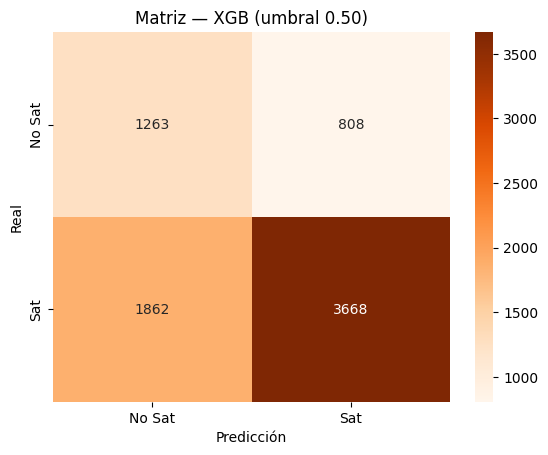

🔎 Umbral óptimo para clase 0: {'thr': np.float64(0.56), 'f1_0': 0.49508196721311476, 'rec0': 0.7291163689039112, 'prec0': 0.37478282452221395}
📌 Report (umbral óptimo clase 0):
              precision    recall  f1-score   support

           0       0.37      0.73      0.50      2071
           1       0.84      0.54      0.66      5530

    accuracy                           0.59      7601
   macro avg       0.61      0.64      0.58      7601
weighted avg       0.72      0.59      0.62      7601



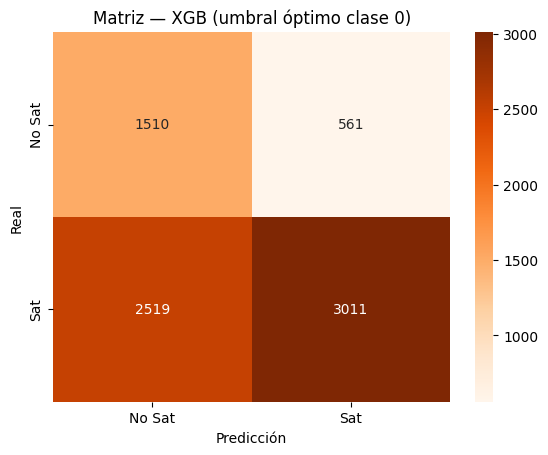

In [20]:
# ===== XGBoost con early stopping (API nativa) + pesos clase 0 + ajuste de umbral =====
print("XGBoost version:", xgb.__version__)

# 1) Split interno para validación
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42, stratify=y_train
)

# 2) Pesos para favorecer la clase 0 (insatisfechos)
ratio = (y_tr == 1).sum() / max(1, (y_tr == 0).sum())
sample_w = np.where(y_tr == 0, ratio, 1.0)

# 3) DMatrix (requerido por API nativa)
dtrain = xgb.DMatrix(X_tr, label=y_tr, weight=sample_w)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test)

# 4) Parámetros equivalentes
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 5,
    'eta': 0.05,                # = learning_rate
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'min_child_weight': 1,
    'lambda': 1.0,              # = reg_lambda
    'alpha': 0.0,               # = reg_alpha
    'tree_method': 'hist',
    'seed': 42
}

# 5) Entrenamiento con early stopping estable
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=False
)
print(f"Mejor iteración: {booster.best_iteration} | Mejor logloss(valid): {booster.best_score:.4f}")

# 6) Predicción en TEST respetando mejor iteración
try:
    y_proba = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1))
except TypeError:
    # Fallback por compatibilidad
    y_proba = booster.predict(dtest)

# --- Report con umbral 0.50 ---
y_pred = (y_proba >= 0.50).astype(int)
print("📌 Report (umbral 0.50):")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Sat', 'Sat'], yticklabels=['No Sat', 'Sat'])
plt.title("Matriz — XGB (umbral 0.50)")
plt.xlabel("Predicción"); plt.ylabel("Real"); plt.show()

# 7) Búsqueda de umbral óptimo para maximizar F1 de la clase 0
def umbral_optimo_clase0(y_true, proba_pos):
    best = {'thr':0.5, 'f1_0':-1, 'rec0':0, 'prec0':0}
    for thr in np.linspace(0.1, 0.9, 81):
        y_hat = (proba_pos >= thr).astype(int)        # proba de clase 1
        f1_0  = f1_score(y_true, y_hat, pos_label=0)
        rec0  = recall_score(y_true, y_hat, pos_label=0)
        prec0 = precision_score(y_true, y_hat, pos_label=0)
        if f1_0 > best['f1_0']:
            best = {'thr':thr, 'f1_0':f1_0, 'rec0':rec0, 'prec0':prec0}
    return best

best = umbral_optimo_clase0(y_test, y_proba)
print("🔎 Umbral óptimo para clase 0:", best)



In [ ]:
# --- Report con umbral óptimo para clase 0 ---
y_pred_opt = (y_proba >= best['thr']).astype(int)
print("📌 Report (umbral óptimo clase 0):")
print(classification_report(y_test, y_pred_opt))

cm_opt = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Sat', 'Sat'], yticklabels=['No Sat', 'Sat'])
plt.title("Matriz — XGB (umbral óptimo clase 0)")
plt.xlabel("Predicción"); plt.ylabel("Real"); plt.show()

In [21]:
# === Celda A: elegir umbral por objetivo de negocio o costo ===

def umbral_por_objetivo(y_true, proba_pos, min_recall0=0.70):
    mejor = {'thr':0.5, 'rec0':0, 'f1_0':-1}
    for thr in np.linspace(0.1, 0.9, 81):
        y_hat = (proba_pos >= thr).astype(int)
        rec0  = recall_score(y_true, y_hat, pos_label=0)
        f1_0v = f1_score(y_true, y_hat, pos_label=0)
        if rec0 >= min_recall0 and f1_0v > mejor['f1_0']:
            mejor = {'thr':thr, 'rec0':rec0, 'f1_0':f1_0v}
    return mejor

def umbral_por_coste(y_true, proba_pos, cost_fn=5.0, cost_fp=1.0):
    mejor = {'thr':0.5, 'costo':float('inf')}
    for thr in np.linspace(0.1, 0.9, 81):
        y_hat = (proba_pos >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        costo = cost_fn*fn + cost_fp*fp
        if costo < mejor['costo']:
            mejor = {'thr':thr, 'costo':costo}
    return mejor

# Usa y_proba de la celda XGB nativa
tgt = umbral_por_objetivo(y_test, y_proba, min_recall0=0.70)
print("🎯 Umbral con recall0 ≥ 0.70:", tgt)

y_hat_obj = (y_proba >= tgt['thr']).astype(int)
print(classification_report(y_test, y_hat_obj))


🎯 Umbral con recall0 ≥ 0.70: {'thr': np.float64(0.56), 'rec0': 0.7291163689039112, 'f1_0': 0.49508196721311476}
              precision    recall  f1-score   support

           0       0.37      0.73      0.50      2071
           1       0.84      0.54      0.66      5530

    accuracy                           0.59      7601
   macro avg       0.61      0.64      0.58      7601
weighted avg       0.72      0.59      0.62      7601



In [22]:
# === Celda B: XGBoost RandomizedSearchCV pro-clase 0 (opcional) ===

# Pesos para favorecer clase 0 en el fit
w_ratio = (y_train==1).sum() / (y_train==0).sum()
sw = np.where(y_train==0, w_ratio, 1.0)

# Scorers que priorizan la clase 0
f1_0     = make_scorer(f1_score,    pos_label=0)
recall_0 = make_scorer(recall_score,pos_label=0)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

xgb_base = XGBClassifier(
    eval_metric='logloss',
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)

param_distributions = {
    'n_estimators':     [300, 600, 900, 1200],
    'learning_rate':    [0.03, 0.05, 0.08, 0.1],
    'max_depth':        [4, 5, 6, 8],
    'min_child_weight': [1, 2, 5],
    'subsample':        [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.85, 1.0],
    'gamma':            [0, 0.3, 1.0],
    'reg_lambda':       [1.0, 3.0, 6.0],
    'reg_alpha':        [0.0, 0.1, 0.5]
}

rand = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=30,
    scoring={'f1_0': f1_0, 'recall_0': recall_0, 'bacc': 'balanced_accuracy'},
    refit='f1_0',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rand.fit(X_train, y_train, sample_weight=sw)
print("🔧 Mejores hiperparámetros:", rand.best_params_)
best_xgb = rand.best_estimator_

# Evaluación en test con umbral 0.50
y_proba_rs = best_xgb.predict_proba(X_test)[:,1]
y_pred_rs  = (y_proba_rs >= 0.50).astype(int)
print("📌 Report Randomized (0.50):")
print(classification_report(y_test, y_pred_rs))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rs))

# (opcional) aplicar el mismo criterio de umbral que en la celda A:
tgt_rs = umbral_por_objetivo(y_test, y_proba_rs, min_recall0=0.70)
print("🎯 Umbral RS con recall0 ≥ 0.70:", tgt_rs)
y_hat_rs = (y_proba_rs >= tgt_rs['thr']).astype(int)
print(classification_report(y_test, y_hat_rs))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
🔧 Mejores hiperparámetros: {'subsample': 0.85, 'reg_lambda': 1.0, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
📌 Report Randomized (0.50):
              precision    recall  f1-score   support

           0       0.40      0.63      0.49      2071
           1       0.82      0.65      0.72      5530

    accuracy                           0.64      7601
   macro avg       0.61      0.64      0.61      7601
weighted avg       0.71      0.64      0.66      7601

ROC-AUC: 0.6984764634848065
🎯 Umbral RS con recall0 ≥ 0.70: {'thr': np.float64(0.54), 'rec0': 0.7286335103814582, 'f1_0': 0.49362119725220804}
              precision    recall  f1-score   support

           0       0.37      0.73      0.49      2071
           1       0.84      0.54      0.66      5530

    accuracy                           0.59      7601
   macro avg     

In [23]:
# Elegí en cuáles columnas aplicar encoding adicional (de las que TENÉS en X)
cand_cols = [c for c in ['Producto_sf','Subproduct_sf','grupo_producto',
                         'motivo_contacto_categoria','rango_etario','genero',
                         'ya_es_cliente']
             if c in X_train.columns]

def add_freq_and_target_mean(Xtr, Xte, ytr, cols, positive_class=0):
    Xtr = Xtr.copy(); Xte = Xte.copy()
    for col in cols:
        # Frequency encoding (proporción de cada categoría en train)
        freq = Xtr[col].value_counts(normalize=True)
        Xtr[f'{col}_freq'] = Xtr[col].map(freq)
        Xte[f'{col}_freq'] = Xte[col].map(freq).fillna(0)

        # Target-mean encoding para clase 0 (prob de ser clase 0 por categoría)
        # Nota: calculado SOLO en train para evitar fuga
        tmp = pd.DataFrame({col: Xtr[col], 'y': ytr})
        # prob de clase 0:
        mean0 = tmp.groupby(col)['y'].apply(lambda v: (v==positive_class).mean())
        global_mean0 = (ytr==positive_class).mean()
        Xtr[f'{col}_mean0'] = Xtr[col].map(mean0)
        Xte[f'{col}_mean0'] = Xte[col].map(mean0).fillna(global_mean0)

    return Xtr, Xte

X_train_ext, X_test_ext = add_freq_and_target_mean(X_train, X_test, y_train, cand_cols, positive_class=0)
print("Columns added:",
      [c for c in X_train_ext.columns if c.endswith('_freq') or c.endswith('_mean0')])
print("Shapes -> X_train_ext:", X_train_ext.shape, "| X_test_ext:", X_test_ext.shape)


Columns added: ['Producto_sf_freq', 'Producto_sf_mean0', 'Subproduct_sf_freq', 'Subproduct_sf_mean0', 'motivo_contacto_categoria_freq', 'motivo_contacto_categoria_mean0', 'rango_etario_freq', 'rango_etario_mean0', 'genero_freq', 'genero_mean0', 'ya_es_cliente_freq', 'ya_es_cliente_mean0']
Shapes -> X_train_ext: (30404, 20) | X_test_ext: (7601, 20)


In [24]:
print("X_train cols:", X_train.columns.tolist())

candidatas = ['Producto_sf','Subproduct_sf','grupo_producto',
              'motivo_contacto_categoria','rango_etario','genero','ya_es_cliente',
              'ciudad','Canal','canal_ticket']
faltan = [c for c in candidatas if c not in X_train.columns]
print("❗ No están en X_train:", faltan)

X_train cols: ['antiguedad_cliente_meses', 'rango_etario', 'genero', 'ya_es_cliente', 'Recontacto_sf', 'Producto_sf', 'Subproduct_sf', 'motivo_contacto_categoria']
❗ No están en X_train: ['grupo_producto', 'ciudad', 'Canal', 'canal_ticket']


Mejor iteración: 252 | Mejor logloss(valid): 0.6155
📌 Report (umbral 0.50) con features extra:
              precision    recall  f1-score   support

           0       0.40      0.63      0.49      2071
           1       0.82      0.65      0.73      5530

    accuracy                           0.64      7601
   macro avg       0.61      0.64      0.61      7601
weighted avg       0.71      0.64      0.66      7601

ROC-AUC: 0.701690135802868


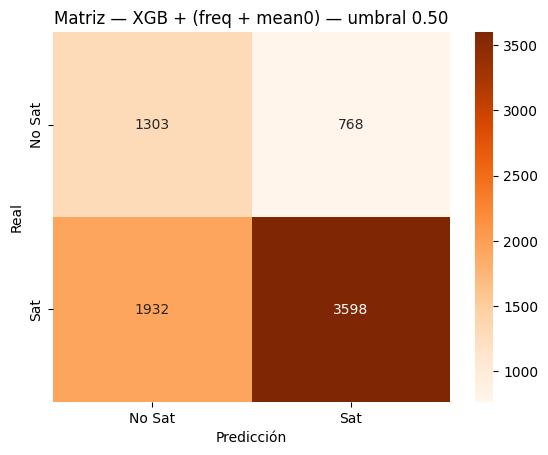

In [25]:

# Split interno para early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_ext, y_train, test_size=0.10, random_state=42, stratify=y_train
)

# Pesos a clase 0 (minoritaria)
ratio = (y_tr==1).sum() / max(1, (y_tr==0).sum())
sw = np.where(y_tr==0, ratio, 1.0)

# DMatrix
dtrain = xgb.DMatrix(X_tr, label=y_tr, weight=sw)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test_ext)

# Parámetros (conservadores, buenos para recall_0)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 5,
    'eta': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'min_child_weight': 2,
    'lambda': 1.0,
    'alpha': 0.5,
    'tree_method': 'hist',
    'seed': 42
}

booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=[(dtrain,'train'), (dvalid,'valid')],
    early_stopping_rounds=50,
    verbose_eval=False
)

print(f"Mejor iteración: {booster.best_iteration} | Mejor logloss(valid): {booster.best_score:.4f}")

# Predicciones test
y_proba_ext = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1))
y_pred05    = (y_proba_ext >= 0.50).astype(int)

print("📌 Report (umbral 0.50) con features extra:")
print(classification_report(y_test, y_pred05))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_ext))

cm = confusion_matrix(y_test, y_pred05)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Sat','Sat'], yticklabels=['No Sat','Sat'])
plt.title("Matriz — XGB + (freq + mean0) — umbral 0.50")
plt.xlabel("Predicción"); plt.ylabel("Real"); plt.show()


🎯 Umbral con recall0 ≥ 0.70: {'thr': np.float64(0.58), 'rec0': 0.7981651376146789, 'f1_0': 0.49744207041829674}
📌 Report (umbral objetivo):
              precision    recall  f1-score   support

           0       0.36      0.80      0.50      2071
           1       0.86      0.47      0.61      5530

    accuracy                           0.56      7601
   macro avg       0.61      0.63      0.55      7601
weighted avg       0.73      0.56      0.58      7601



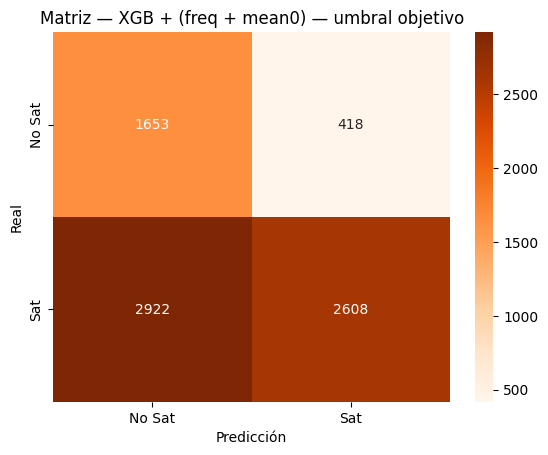

In [26]:
import numpy as np
from sklearn.metrics import classification_report, recall_score, f1_score, confusion_matrix

def umbral_por_objetivo(y_true, proba_pos, min_recall0=0.70):
    mejor = {'thr':0.5, 'rec0':0, 'f1_0':-1}
    for thr in np.linspace(0.1, 0.9, 81):
        y_hat = (proba_pos >= thr).astype(int)
        rec0  = recall_score(y_true, y_hat, pos_label=0)
        f1_0v = f1_score(y_true, y_hat, pos_label=0)
        if rec0 >= min_recall0 and f1_0v > mejor['f1_0']:
            mejor = {'thr':thr, 'rec0':rec0, 'f1_0':f1_0v}
    return mejor

best_obj = umbral_por_objetivo(y_test, y_proba_ext, min_recall0=0.70)
print("🎯 Umbral con recall0 ≥ 0.70:", best_obj)

y_hat_obj = (y_proba_ext >= best_obj['thr']).astype(int)
print("📌 Report (umbral objetivo):")
print(classification_report(y_test, y_hat_obj))

cm2 = confusion_matrix(y_test, y_hat_obj)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Sat','Sat'], yticklabels=['No Sat','Sat'])
plt.title("Matriz — XGB + (freq + mean0) — umbral objetivo")
plt.xlabel("Predicción"); plt.ylabel("Real"); plt.show()


In [27]:
#Para evitar que variables viejas se mezclen, podés limpiar algunas antes de empezar la parte nueva:

for name in ['X_train_ext','X_test_ext','y_proba','y_pred']:
    if name in globals(): del globals()[name]


In [28]:
# Celda NUEVA: features extra
cand_cols = [c for c in [
    'Producto_sf','Subproduct_sf','grupo_producto','motivo_contacto_categoria',
    'rango_etario','genero','ya_es_cliente','ciudad','Canal','canal_ticket'
] if c in X_train.columns]

def add_freq_and_target_mean(Xtr, Xte, ytr, cols, positive_class=0):
    Xtr = Xtr.copy(); Xte = Xte.copy()
    base_p0 = (ytr == positive_class).mean()  # prob global de clase 0

    for col in cols:
        # Frequency encoding
        freq = Xtr[col].value_counts(normalize=True)
        Xtr[f'{col}_freq'] = Xtr[col].map(freq)
        Xte[f'{col}_freq'] = Xte[col].map(freq).fillna(0)

        # Target-mean encoding (prob de ser clase 0)
        tmp = pd.DataFrame({col: Xtr[col], 'y': ytr.values})
        # y es 0/1 → prob0 = 1 - mean(y)
        mean1 = tmp.groupby(col)['y'].mean()        # P(y=1 | col)
        prob0 = 1.0 - mean1                         # P(y=0 | col)
        Xtr[f'{col}_mean0'] = Xtr[col].map(prob0)
        Xte[f'{col}_mean0'] = Xte[col].map(prob0).fillna(base_p0)

    return Xtr, Xte


X_train_ext, X_test_ext = add_freq_and_target_mean(X_train, X_test, y_train, cand_cols, positive_class=0)

print("➕ Nuevas columnas:", [c for c in X_train_ext.columns if c.endswith('_freq') or c.endswith('_mean0')])
print("📐 Shapes:", X_train_ext.shape, X_test_ext.shape)


➕ Nuevas columnas: ['Producto_sf_freq', 'Producto_sf_mean0', 'Subproduct_sf_freq', 'Subproduct_sf_mean0', 'motivo_contacto_categoria_freq', 'motivo_contacto_categoria_mean0', 'rango_etario_freq', 'rango_etario_mean0', 'genero_freq', 'genero_mean0', 'ya_es_cliente_freq', 'ya_es_cliente_mean0']
📐 Shapes: (30404, 20) (7601, 20)


Mejor iteración: 252 | logloss(valid): 0.6155
📌 Report (0.50):
              precision    recall  f1-score   support

           0       0.40      0.63      0.49      2071
           1       0.82      0.65      0.73      5530

    accuracy                           0.64      7601
   macro avg       0.61      0.64      0.61      7601
weighted avg       0.71      0.64      0.66      7601

ROC-AUC: 0.701690135802868


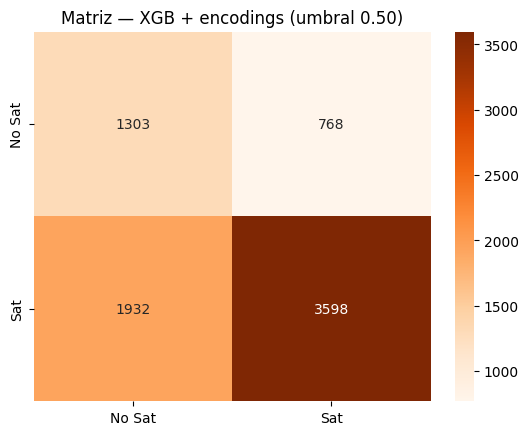

🎯 Umbral con recall0 ≥ 0.70: {'thr': np.float64(0.58), 'rec0': 0.7981651376146789, 'f1_0': 0.49744207041829674}
📌 Report (umbral objetivo):
              precision    recall  f1-score   support

           0       0.36      0.80      0.50      2071
           1       0.86      0.47      0.61      5530

    accuracy                           0.56      7601
   macro avg       0.61      0.63      0.55      7601
weighted avg       0.73      0.56      0.58      7601



In [29]:
# Celda NUEVA: XGBoost nativo + early stopping con X_train_ext/X_test_ext
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, recall_score
import numpy as np, seaborn as sns, matplotlib.pyplot as plt

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_ext, y_train, test_size=0.10, random_state=42, stratify=y_train
)
ratio = (y_tr==1).sum() / max(1,(y_tr==0).sum())
sw = np.where(y_tr==0, ratio, 1.0)

dtrain = xgb.DMatrix(X_tr,  label=y_tr, weight=sw)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test_ext)

params = {
    'objective':'binary:logistic','eval_metric':'logloss','max_depth':5,'eta':0.05,
    'subsample':0.9,'colsample_bytree':0.9,'min_child_weight':2,'lambda':1.0,'alpha':0.5,
    'tree_method':'hist','seed':42
}
booster = xgb.train(params, dtrain, num_boost_round=2000,
                    evals=[(dtrain,'train'),(dvalid,'valid')],
                    early_stopping_rounds=50, verbose_eval=False)

print(f"Mejor iteración: {booster.best_iteration} | logloss(valid): {booster.best_score:.4f}")

y_proba = booster.predict(dtest, iteration_range=(0, booster.best_iteration+1))
y_pred  = (y_proba >= 0.50).astype(int)
print("📌 Report (0.50):"); print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Sat','Sat'], yticklabels=['No Sat','Sat'])
plt.title("Matriz — XGB + encodings (umbral 0.50)"); plt.show()

# Umbral por objetivo de negocio (ej. recall0 ≥ 0.70)
def umbral_por_objetivo(y_true, proba_pos, min_recall0=0.70):
    best = {'thr':0.5, 'rec0':0, 'f1_0':-1}
    for thr in np.linspace(0.1,0.9,81):
        y_hat = (proba_pos >= thr).astype(int)
        rec0  = recall_score(y_true, y_hat, pos_label=0)
        f1_0v = f1_score(y_true, y_hat, pos_label=0)
        if rec0 >= min_recall0 and f1_0v > best['f1_0']:
            best = {'thr':thr, 'rec0':rec0, 'f1_0':f1_0v}
    return best

best_obj = umbral_por_objetivo(y_test, y_proba, min_recall0=0.70)
print("🎯 Umbral con recall0 ≥ 0.70:", best_obj)
y_hat_obj = (y_proba >= best_obj['thr']).astype(int)
print("📌 Report (umbral objetivo):"); print(classification_report(y_test, y_hat_obj))


In [30]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

umbral_final = 0.58  # ajustalo con el valor que te salió (p.ej. 0.58)
y_pred_final = (y_proba >= umbral_final).astype(int)

print(f"👉 Umbral fijado: {umbral_final:.2f}")
print(classification_report(y_test, y_pred_final))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final).ravel()
print("Confusión:", {'tn':int(tn),'fp':int(fp),'fn':int(fn),'tp':int(tp)})
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

resultados = {
    'umbral': umbral_final,
    'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp),
    'auc': float(roc_auc_score(y_test, y_proba))
}
resultados


👉 Umbral fijado: 0.58
              precision    recall  f1-score   support

           0       0.36      0.80      0.50      2071
           1       0.86      0.47      0.61      5530

    accuracy                           0.56      7601
   macro avg       0.61      0.63      0.55      7601
weighted avg       0.73      0.56      0.58      7601

Confusión: {'tn': 1653, 'fp': 418, 'fn': 2922, 'tp': 2608}
ROC-AUC: 0.701690135802868


{'umbral': 0.58,
 'tn': 1653,
 'fp': 418,
 'fn': 2922,
 'tp': 2608,
 'auc': 0.701690135802868}

In [31]:
# Importancias (ganancia) del booster nativo
imp = booster.get_score(importance_type='gain')
top10 = sorted(imp.items(), key=lambda x: -x[1])[:10]
print("🔝 Top 10 features (gain):")
for k,v in top10:
    print(f"{k}: {v:.4f}")


🔝 Top 10 features (gain):
Recontacto_sf: 54.2309
Subproduct_sf_mean0: 50.0135
Producto_sf_mean0: 15.1437
motivo_contacto_categoria_mean0: 12.9643
rango_etario_mean0: 8.4441
rango_etario: 7.9148
motivo_contacto_categoria: 7.5367
genero_mean0: 7.1349
motivo_contacto_categoria_freq: 6.1821
Subproduct_sf_freq: 6.1564


In [32]:
# 🔒 Experimento A/B: quitar Recontacto_sf y reentrenar rápido sobre las features extendidas
cols_sin_recontacto = [c for c in X_train_ext.columns if c != 'Recontacto_sf']
dtrain_ab = xgb.DMatrix(X_tr[cols_sin_recontacto], label=y_tr, weight=sw)
dvalid_ab = xgb.DMatrix(X_val[cols_sin_recontacto], label=y_val)
dtest_ab  = xgb.DMatrix(X_test_ext[cols_sin_recontacto])

booster_ab = xgb.train(params, dtrain_ab, num_boost_round=2000,
                       evals=[(dtrain_ab,'train'),(dvalid_ab,'valid')],
                       early_stopping_rounds=50, verbose_eval=False)

y_proba_ab = booster_ab.predict(dtest_ab, iteration_range=(0, booster_ab.best_iteration+1))
y_pred_ab  = (y_proba_ab >= 0.58).astype(int)  # usa tu umbral final para comparar
print(classification_report(y_test, y_pred_ab))


              precision    recall  f1-score   support

           0       0.35      0.82      0.49      2071
           1       0.87      0.44      0.58      5530

    accuracy                           0.54      7601
   macro avg       0.61      0.63      0.54      7601
weighted avg       0.73      0.54      0.56      7601



[('Recontacto_sf', 54.23094177246094), ('Subproduct_sf_mean0', 50.01350784301758), ('Producto_sf_mean0', 15.14374828338623), ('motivo_contacto_categoria_mean0', 12.964268684387207), ('rango_etario_mean0', 8.444083213806152), ('rango_etario', 7.9147725105285645), ('motivo_contacto_categoria', 7.536660194396973), ('genero_mean0', 7.1349005699157715), ('motivo_contacto_categoria_freq', 6.182089328765869), ('Subproduct_sf_freq', 6.156386375427246)]


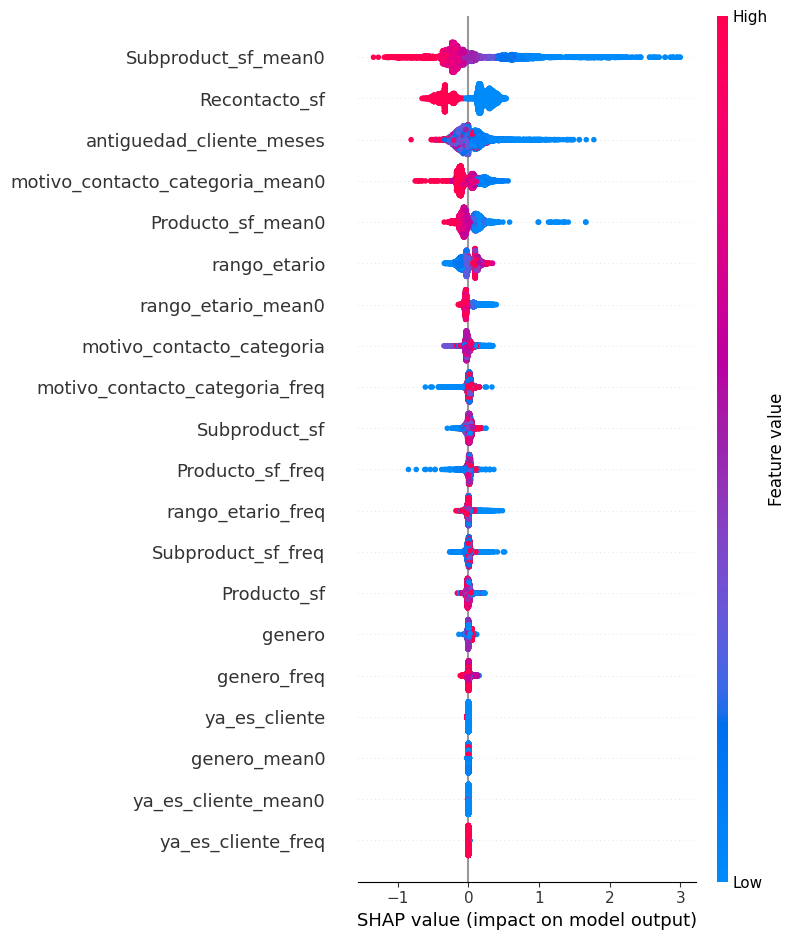

In [33]:
# Importancias (ya viste el top10 por 'gain')
imp = booster.get_score(importance_type='gain')
print(sorted(imp.items(), key=lambda x: -x[1])[:10])

# (Opcional) SHAP rápido
# !pip install shap
import shap
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(xgb.DMatrix(X_test_ext))
shap.summary_plot(shap_values, X_test_ext, show=False)  # en Colab, luego plt.show()


In [34]:
# ===== Reentrenar XGB nativo SIN Recontacto_sf =====
import numpy as np, xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, recall_score

# 1) Subset de features SIN Recontacto_sf
cols_sin_recontacto = [c for c in X_train_ext.columns if c != 'Recontacto_sf']
X_tr_full = X_train_ext[cols_sin_recontacto]
X_te_full = X_test_ext[cols_sin_recontacto]

# 2) Split interno p/ early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr_full, y_train, test_size=0.10, random_state=42, stratify=y_train
)

# 3) Pesos favoreciendo clase 0
ratio = (y_tr==1).sum() / max(1,(y_tr==0).sum())
sw = np.where(y_tr==0, ratio, 1.0)

# 4) DMatrix
dtrain = xgb.DMatrix(X_tr, label=y_tr, weight=sw)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_te_full)

# 5) Parámetros (mismos que venías usando)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 5,
    'eta': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'min_child_weight': 2,
    'lambda': 1.0,
    'alpha': 0.5,
    'tree_method': 'hist',
    'seed': 42
}

booster_sin = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=[(dtrain,'train'),(dvalid,'valid')],
    early_stopping_rounds=50,
    verbose_eval=False
)
print(f"Mejor iteración (sin Recontacto): {booster_sin.best_iteration} | logloss(valid): {booster_sin.best_score:.4f}")

# 6) Predicciones test
y_proba_sin = booster_sin.predict(dtest, iteration_range=(0, booster_sin.best_iteration+1))

# Report con umbral 0.50 (referencia)
y_pred050 = (y_proba_sin >= 0.50).astype(int)
print("📌 Report (0.50) sin Recontacto:")
print(classification_report(y_test, y_pred050))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_sin))

# 7) Elegir umbral para recall_0 ≥ 0.70 (o tu objetivo)
def umbral_por_objetivo(y_true, proba_pos, min_recall0=0.70):
    best = {'thr':0.5, 'rec0':0, 'f1_0':-1}
    for thr in np.linspace(0.1, 0.9, 81):
        y_hat = (proba_pos >= thr).astype(int)
        r0 = recall_score(y_true, y_hat, pos_label=0)
        f10 = f1_score(y_true, y_hat, pos_label=0)
        if r0 >= min_recall0 and f10 > best['f1_0']:
            best = {'thr':thr, 'rec0':r0, 'f1_0':f10}
    return best

best_obj_sin = umbral_por_objetivo(y_test, y_proba_sin, min_recall0=0.70)
print("🎯 Umbral (sin Recontacto) con recall0 ≥ 0.70:", best_obj_sin)

y_hat_obj_sin = (y_proba_sin >= best_obj_sin['thr']).astype(int)
print("📌 Report (umbral objetivo) sin Recontacto:")
print(classification_report(y_test, y_hat_obj_sin))


Mejor iteración (sin Recontacto): 282 | logloss(valid): 0.6325
📌 Report (0.50) sin Recontacto:
              precision    recall  f1-score   support

           0       0.38      0.68      0.49      2071
           1       0.83      0.59      0.69      5530

    accuracy                           0.61      7601
   macro avg       0.60      0.63      0.59      7601
weighted avg       0.71      0.61      0.63      7601

ROC-AUC: 0.6810369757863477
🎯 Umbral (sin Recontacto) con recall0 ≥ 0.70: {'thr': np.float64(0.56), 'rec0': 0.7880251086431675, 'f1_0': 0.4950705293493099}
📌 Report (umbral objetivo) sin Recontacto:
              precision    recall  f1-score   support

           0       0.36      0.79      0.50      2071
           1       0.86      0.48      0.61      5530

    accuracy                           0.56      7601
   macro avg       0.61      0.63      0.55      7601
weighted avg       0.72      0.56      0.58      7601



In [35]:
bins = [-0.1,6,12,24,60,1e9]; labels = ['<6m','6-12m','12-24m','2-5y','5y+']
df['antiguedad_bucket'] = pd.cut(df['antiguedad_cliente_meses'], bins=bins, labels=labels)
# añadila a whitelist, recodificá, rearmá X_train/X_test y vuelve a crear *_freq/_mean0


In [36]:
# Guardar modelo, umbral y listado de features
booster_sin.save_model("xgb_csat_sin_recontacto.json")

umbral_final = 0.56   # o 0.58, el que elijas
np.save("umbral_final.npy", np.array([umbral_final]))

cols_sin_recontacto = [c for c in X_train_ext.columns if c != 'Recontacto_sf']
with open("features_usadas.txt", "w") as f:
    f.write("\n".join(cols_sin_recontacto))



Temporal shapes: (14351, 14) (7628, 14)
Mejor iteración (temporal): 346 | logloss(valid): 0.5735
📌 Report temporal (umbral 0.50):
              precision    recall  f1-score   support

           0       0.36      0.44      0.40      1640
           1       0.84      0.79      0.81      5988

    accuracy                           0.71      7628
   macro avg       0.60      0.61      0.60      7628
weighted avg       0.74      0.71      0.72      7628

ROC-AUC temporal: 0.6651782732130929
🎯 Umbral temporal con recall0 ≥ 0.70: {'thr': np.float64(0.66), 'rec0': 0.7146341463414634, 'f1_0': 0.4039290022402206}
📌 Report temporal (umbral objetivo):
              precision    recall  f1-score   support

           0       0.28      0.71      0.40      1640
           1       0.86      0.50      0.63      5988

    accuracy                           0.55      7628
   macro avg       0.57      0.61      0.52      7628
weighted avg       0.74      0.55      0.58      7628



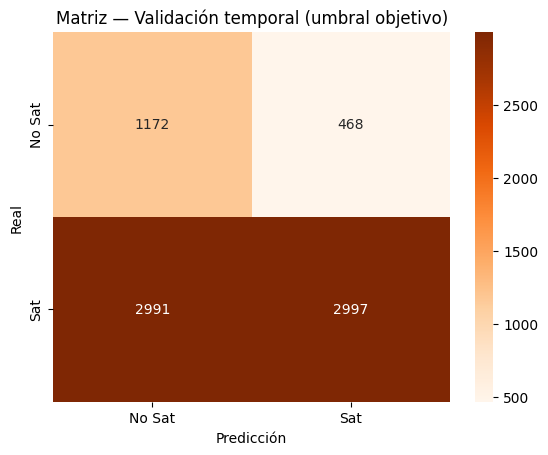

In [37]:
# ----------------------------
# 1) Asegurar columna de MES
# ----------------------------
# Usaremos 'mes_encuesta' si ya existe. Si no, la creamos desde alguna fecha disponible.
if 'mes_encuesta' not in df.columns:
    # Intentar a partir de fecha_encuesta o columnas similares
    posibles = ['Fecha Registrada corta','Fecha registrada']
    col_fecha = next((c for c in posibles if c in df.columns), None)
    if col_fecha is None:
        raise ValueError("No encuentro una columna de fecha para inferir el mes.")
    df[col_fecha] = pd.to_datetime(df[col_fecha], errors='coerce')
    df['mes_encuesta'] = df[col_fecha].dt.month

# ----------------------------
# 2) Reconstruir df_modelo limpio (whitelist)
# ----------------------------
whitelist = [
    'antiguedad_cliente_meses','rango_etario','genero','ya_es_cliente','ciudad',
    'Producto_sf','Subproduct_sf','grupo_producto','motivo_contacto_categoria',
    'Canal','canal_ticket','Duración (en segundos)','mes_encuesta','dia_semana_encuesta','hora_encuesta'
]
cols_exist = [c for c in whitelist if c in df.columns]
df_modelo = df[cols_exist + ['CSAT_bin']].copy()

# Anti-fuga (por si se coló algo de CSAT o Resolución textual)
ban_patterns = ['csat','satisf','resoluc']
bad = [c for c in df_modelo.columns if any(p in c.lower() for p in ban_patterns) and c!='CSAT_bin']
if bad:
    df_modelo = df_modelo.drop(columns=bad)

# ----------------------------
# 3) Codificar categóricas SOLO en object/category
# ----------------------------
X_raw = df_modelo.drop(columns=['CSAT_bin']).copy()
y_all = df_modelo['CSAT_bin'].astype(int)
for col in X_raw.select_dtypes(include=['object','category']).columns:
    le = LabelEncoder()
    X_raw[col] = le.fit_transform(X_raw[col].astype(str))

# ----------------------------
# 4) Imputación (fit en TRAIN temporal)
# ----------------------------
# Definir máscaras temporales
mask_train = df['mes_encuesta'].isin([2,3,4])  # Feb-Abr
mask_test  = df['mes_encuesta'].isin([5,6])    # May-Jun

imp = SimpleImputer(strategy='mean')
X_train_ts = pd.DataFrame(imp.fit_transform(X_raw[mask_train]), columns=X_raw.columns, index=X_raw[mask_train].index)
X_test_ts  = pd.DataFrame(imp.transform(X_raw[mask_test]),  columns=X_raw.columns, index=X_raw[mask_test].index)
y_train_ts = y_all[mask_train]
y_test_ts  = y_all[mask_test]

print("Temporal shapes:", X_train_ts.shape, X_test_ts.shape)

# ----------------------------
# 5) Encodings adicionales: *_freq y *_mean0 (fit SOLO en train temporal)
# ----------------------------
cand_cols = [c for c in [
    'Producto_sf','Subproduct_sf','grupo_producto','motivo_contacto_categoria',
    'rango_etario','genero','ya_es_cliente','ciudad','Canal','canal_ticket'
] if c in X_train_ts.columns]

def add_freq_and_target_mean(Xtr, Xte, ytr, cols, positive_class=0):
    Xtr = Xtr.copy(); Xte = Xte.copy()
    base_p0 = (ytr == positive_class).mean()
    for col in cols:
        # frequency
        freq = Xtr[col].value_counts(normalize=True)
        Xtr[f'{col}_freq'] = Xtr[col].map(freq)
        Xte[f'{col}_freq'] = Xte[col].map(freq).fillna(0)
        # target-mean (prob de clase 0)
        tmp = pd.DataFrame({col: Xtr[col], 'y': ytr.values})
        mean1 = tmp.groupby(col)['y'].mean()
        prob0 = 1.0 - mean1
        Xtr[f'{col}_mean0'] = Xtr[col].map(prob0)
        Xte[f'{col}_mean0'] = Xte[col].map(prob0).fillna(base_p0)
    return Xtr, Xte

X_tr_ext, X_te_ext = add_freq_and_target_mean(X_train_ts, X_test_ts, y_train_ts, cand_cols, positive_class=0)

# ----------------------------
# 6) Entrenar XGB nativo con early stopping (solo TRAIN temporal)
# ----------------------------
import xgboost as xgb
ratio = (y_train_ts==1).sum() / max(1,(y_train_ts==0).sum())
sw = np.where(y_train_ts==0, ratio, 1.0)

# split interno para early stopping dentro del TRAIN temporal
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_tr_ext, y_train_ts, test_size=0.10, random_state=42, stratify=y_train_ts)

dtrain = xgb.DMatrix(X_tr,  label=y_tr,  weight=np.where(y_tr==0, ratio, 1.0))
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_te_ext)

params = {
    'objective':'binary:logistic','eval_metric':'logloss',
    'max_depth':5,'eta':0.05,'subsample':0.9,'colsample_bytree':0.9,
    'min_child_weight':2,'lambda':1.0,'alpha':0.5,'tree_method':'hist','seed':42
}
booster_ts = xgb.train(params, dtrain, num_boost_round=2000,
                       evals=[(dtrain,'train'),(dvalid,'valid')],
                       early_stopping_rounds=50, verbose_eval=False)

print(f"Mejor iteración (temporal): {booster_ts.best_iteration} | logloss(valid): {booster_ts.best_score:.4f}")

# ----------------------------
# 7) Evaluación en TEST temporal (May-Jun)
# ----------------------------
y_proba_ts = booster_ts.predict(dtest, iteration_range=(0, booster_ts.best_iteration+1))
y_pred050  = (y_proba_ts >= 0.50).astype(int)
print("📌 Report temporal (umbral 0.50):")
print(classification_report(y_test_ts, y_pred050))
print("ROC-AUC temporal:", roc_auc_score(y_test_ts, y_proba_ts))

# Umbral por objetivo (ej: recall0 ≥ 0.70)
def umbral_por_objetivo(y_true, proba_pos, min_recall0=0.70):
    best = {'thr':0.5, 'rec0':0, 'f1_0':-1}
    for thr in np.linspace(0.1,0.9,81):
        y_hat = (proba_pos >= thr).astype(int)
        r0 = recall_score(y_true, y_hat, pos_label=0)
        f10 = f1_score(y_true, y_hat, pos_label=0)
        if r0 >= min_recall0 and f10 > best['f1_0']:
            best = {'thr':thr, 'rec0':r0, 'f1_0':f10}
    return best

best_obj_ts = umbral_por_objetivo(y_test_ts, y_proba_ts, min_recall0=0.70)
print("🎯 Umbral temporal con recall0 ≥ 0.70:", best_obj_ts)

y_hat_ts = (y_proba_ts >= best_obj_ts['thr']).astype(int)
print("📌 Report temporal (umbral objetivo):")
print(classification_report(y_test_ts, y_hat_ts))

sns.heatmap(confusion_matrix(y_test_ts, y_hat_ts), annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Sat','Sat'], yticklabels=['No Sat','Sat'])
plt.title("Matriz — Validación temporal (umbral objetivo)")
plt.xlabel("Predicción"); plt.ylabel("Real"); plt.show()


In [38]:
# Modelo (entrenado en Feb–Abr) + umbral encontrado para May–Jun
booster_ts.save_model("xgb_csat_temporal_febabr.json")

import numpy as np
np.save("umbral_temporal.npy", np.array([float(best_obj_ts['thr'])]))  # ej: 0.66

# Columnas usadas y su orden
with open("features_temporal.txt","w") as f:
    f.write("\n".join(X_tr_ext.columns.astype(str)))


In [39]:
from sklearn.metrics import confusion_matrix

def confusion_clase0(y_true, y_hat):
    # tratamos "0" como la clase positiva
    y_true0 = (y_true == 0).astype(int)
    y_hat0  = (y_hat  == 0).astype(int)
    tn0, fp0, fn0, tp0 = confusion_matrix(y_true0, y_hat0).ravel()
    return tn0, fp0, fn0, tp0  # tp0 = aciertos "No Sat"; fn0 = "No Sat" perdidos

def umbral_por_coste_clase0(y_true, proba_pos, cost_fn=5.0, cost_fp=1.0):
    mejores = {'thr':0.5, 'costo':float('inf'), 'tn0':0,'fp0':0,'fn0':0,'tp0':0}
    import numpy as np
    for thr in np.linspace(0.1, 0.9, 81):
        y_hat = (proba_pos >= thr).astype(int)  # 1="Sat", 0="No Sat"
        tn0, fp0, fn0, tp0 = confusion_clase0(y_true, y_hat)
        costo = cost_fn*fn0 + cost_fp*fp0
        if costo < mejores['costo']:
            mejores = {'thr':float(thr), 'costo':float(costo),
                       'tn0':int(tn0),'fp0':int(fp0),'fn0':int(fn0),'tp0':int(tp0)}
    return mejores

best_cost0 = umbral_por_coste_clase0(y_test_ts, y_proba_ts, cost_fn=5.0, cost_fp=1.0)
best_cost0


{'thr': 0.73,
 'costo': 5282.0,
 'tn0': 2201,
 'fp0': 3787,
 'fn0': 299,
 'tp0': 1341}

In [40]:
from sklearn.metrics import fbeta_score, precision_score, recall_score
import numpy as np

def umbral_por_Fbeta_clase0(y_true, proba_pos, beta=2.0):
    mejor = {'thr':0.5,'fbeta_0':-1,'rec0':0,'prec0':0}
    for thr in np.linspace(0.1, 0.9, 81):
        y_hat = (proba_pos >= thr).astype(int)
        # calculamos F_beta tratando "0" como la clase de interés
        y_true0 = (y_true == 0).astype(int)
        y_hat0  = (y_hat  == 0).astype(int)
        f0 = fbeta_score(y_true0, y_hat0, beta=beta)
        r0 = recall_score(y_true0, y_hat0)
        p0 = precision_score(y_true0, y_hat0, zero_division=0)
        if f0 > mejor['fbeta_0']:
            mejor = {'thr':float(thr),'fbeta_0':float(f0),'rec0':float(r0),'prec0':float(p0)}
    return mejor

best_f2_ts = umbral_por_Fbeta_clase0(y_test_ts, y_proba_ts, beta=2.0)
best_f2_ts


{'thr': 0.88,
 'fbeta_0': 0.5866486850977748,
 'rec0': 0.9548780487804878,
 'prec0': 0.23073522911448358}

In [41]:
import pandas as pd

def comparar_proporciones(df, col, mask_train, mask_test, top_n=10):
    p_train = df.loc[mask_train, col].value_counts(normalize=True)
    p_test  = df.loc[mask_test,  col].value_counts(normalize=True)
    comp = pd.concat([p_train.rename('train'), p_test.rename('test')], axis=1).fillna(0)
    comp['delta_pp'] = (comp['test'] - comp['train'])*100
    return comp.reindex(comp['delta_pp'].abs().sort_values(ascending=False).index).head(top_n)

# Ejemplos (usa columnas que tengas)
cols_cat = [c for c in ['motivo_contacto_categoria','Producto_sf','Subproduct_sf','Canal','ciudad'] if c in df.columns]

for c in cols_cat:
    print(f"\n>>> Drift top en {c}")
    display(comparar_proporciones(df, c, mask_train, mask_test, top_n=10))



>>> Drift top en motivo_contacto_categoria


,train,test,delta_pp
motivo_contacto_categoria,,,
Cuenta/App,0.072260,0.106712,3.445234
Tarjeta,0.187443,0.153907,-3.353672
Otro,0.421782,0.392239,-2.954334
Ofertas/Comercial,0.093722,0.121526,2.780427
Préstamos,0.055327,0.071316,1.598905
Servicios,0.019371,0.013634,-0.573749
Operativo/Soporte,0.038185,0.032512,-0.567369
Transferencias/ Pagos,0.105568,0.102124,-0.344380
Inversiones,0.002718,0.002229,-0.048895



>>> Drift top en Producto_sf


,train,test,delta_pp
Producto_sf,,,
Tarjetas,0.231297,0.167244,-6.405267
Reintegro,0.024199,0.062681,3.848103
Caja de Ahorro y Cuenta corriente,0.086321,0.053148,-3.317291
Tarjeta de credito,0.111480,0.135182,2.370197
Onboarding,0.037111,0.056037,1.892616
Loyalty,0.025601,0.006788,-1.881331
Prestamos,0.040874,0.057337,1.646326
Otros,0.102110,0.118140,1.602973
Préstamos,0.031577,0.047083,1.550522



>>> Drift top en Subproduct_sf


,train,test,delta_pp
Subproduct_sf,,,
Cuentas PF - Mis cuentas,0.120847,0.005936,-11.491148
Mis cuentas,0.008194,0.120168,11.197364
Tarjetas PF - Solicitud de tarjeta,0.112875,0.003040,-10.983426
Tarjetas PF - Mis tarjetas,0.081795,0.003185,-7.861019
Mis tarjetas,0.004208,0.073114,6.890635
Solicitud de tarjeta,0.003470,0.056464,5.299480
Reintegro no procesado,0.024214,0.062835,3.862102
Otras consultas,0.002731,0.038656,3.592500
Solicitud Prestamo,0.001403,0.032865,3.146258



>>> Drift top en ciudad


,train,test,delta_pp
ciudad,,,
ASUNCION,0.355194,0.373915,1.872174
PEDRO JUAN CABALLERO,0.011971,0.008263,-0.370783
LAMBARE,0.039854,0.043382,0.352819
ENCARNACION,0.024240,0.020796,-0.344369
CAPIATA,0.035839,0.032916,-0.292352
LUQUE,0.058592,0.055777,-0.281428
YPANE,0.007659,0.004958,-0.270057
VILLETA,0.004982,0.007575,0.259293
PARAGUARI,0.002008,0.004545,0.253724


In [42]:

def confusion_clase0(y_true, y_hat):
    y_true0 = (y_true == 0).astype(int)
    y_hat0  = (y_hat  == 0).astype(int)
    tn0, fp0, fn0, tp0 = confusion_matrix(y_true0, y_hat0).ravel()
    return tn0, fp0, fn0, tp0

def resumen_umbral(y_true, proba_pos, thr, cost_fn=5.0, cost_fp=1.0):
    y_hat = (proba_pos >= thr).astype(int)    # 1=Sat, 0=No Sat
    tn0, fp0, fn0, tp0 = confusion_clase0(y_true, y_hat)
    prec0 = tp0 / (tp0 + fp0 + 1e-9)
    rec0  = tp0 / (tp0 + fn0 + 1e-9)
    f1_0  = 2*prec0*rec0 / (prec0 + rec0 + 1e-9)
    costo = cost_fn*fn0 + cost_fp*fp0
    return {
        'thr': thr, 'prec0': prec0, 'rec0': rec0, 'f1_0': f1_0,
        'fp0': int(fp0), 'fn0': int(fn0), 'tp0': int(tp0), 'tn0': int(tn0), 'costo': float(costo)
    }

umbrales = [0.50, 0.66, 0.73, 0.88]
tabla = [resumen_umbral(y_test_ts, y_proba_ts, t, cost_fn=5.0, cost_fp=1.0) for t in umbrales]
for row in tabla:
    print(row)


{'thr': 0.5, 'prec0': np.float64(0.36218109054509146), 'rec0': np.float64(0.44146341463387717), 'f1_0': np.float64(0.39791151365688715), 'fp0': 1275, 'fn0': 916, 'tp0': 724, 'tn0': 4713, 'costo': 5855.0}
{'thr': 0.66, 'prec0': np.float64(0.2815277444150176), 'rec0': np.float64(0.7146341463410276), 'f1_0': np.float64(0.403929001834596), 'fp0': 2991, 'fn0': 468, 'tp0': 1172, 'tn0': 2997, 'costo': 5331.0}
{'thr': 0.73, 'prec0': np.float64(0.26150546021835774), 'rec0': np.float64(0.8176829268287698), 'f1_0': np.float64(0.39627659537736504), 'fp0': 3787, 'fn0': 299, 'tp0': 1341, 'tn0': 2201, 'costo': 5282.0}
{'thr': 0.88, 'prec0': np.float64(0.23073522911444955), 'rec0': np.float64(0.9548780487799056), 'f1_0': np.float64(0.3716625130363813), 'fp0': 5221, 'fn0': 74, 'tp0': 1566, 'tn0': 767, 'costo': 5591.0}


In [43]:
# --- Importancias (gain) top 15 ---
imp = booster_ts.get_score(importance_type='gain')
top = sorted(imp.items(), key=lambda x: -x[1])[:15]
for k,v in top:
    print(f"{k}: {v:.4f}")


Subproduct_sf_mean0: 29.2381
Producto_sf_mean0: 17.1168
Duración (en segundos): 15.1779
rango_etario_mean0: 14.5847
ciudad_mean0: 11.2470
mes_encuesta: 9.9669
rango_etario: 7.9630
motivo_contacto_categoria_mean0: 6.5758
Subproduct_sf: 6.1678
antiguedad_cliente_meses: 6.0719
rango_etario_freq: 5.8511
motivo_contacto_categoria: 5.7797
ciudad_freq: 5.5665
ciudad: 5.5330
Subproduct_sf_freq: 5.5313


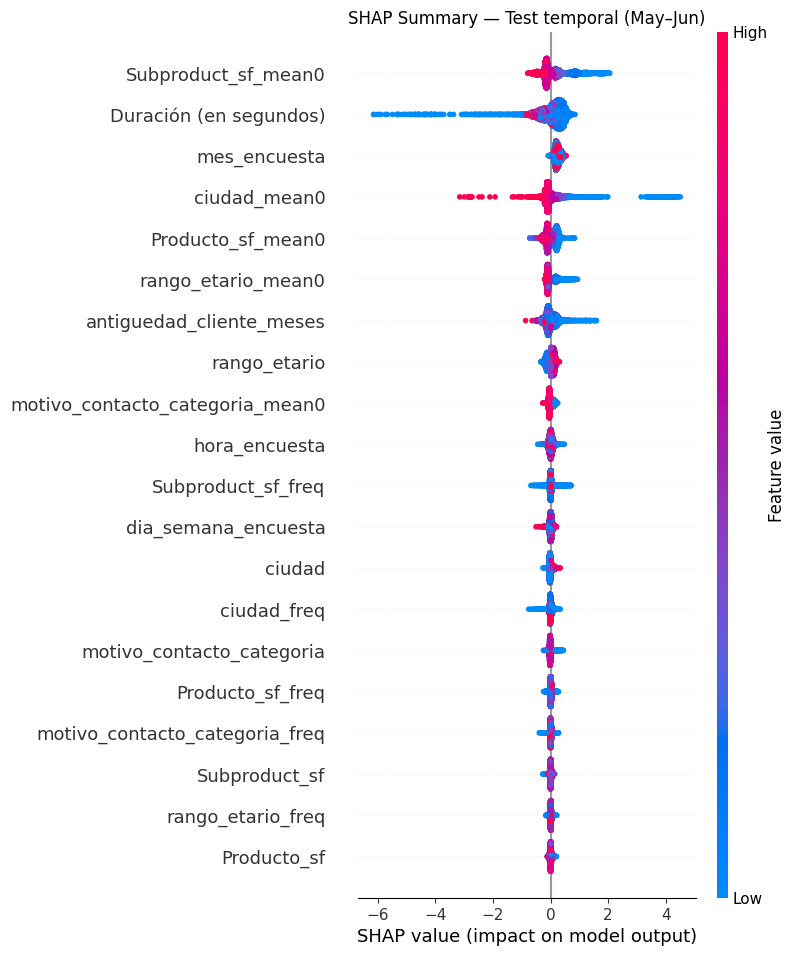

In [44]:
# --- SHAP summary plot ---
# !pip install shap

# Usamos el mismo booster_ts y X_te_ext de la validación temporal
explainer = shap.TreeExplainer(booster_ts)
# OJO: SHAP espera matriz/array, pasamos el mismo orden de columnas
X_plot = X_te_ext.copy()
shap_values = explainer.shap_values(xgb.DMatrix(X_plot))

shap.summary_plot(shap_values, X_plot, show=False)
plt.title("SHAP Summary — Test temporal (May–Jun)")
plt.show()


In [45]:

#from sklearn.metrics import confusion_matrix

def confusion_clase0(y_true, y_hat):
    y_true0=(y_true==0).astype(int); y_hat0=(y_hat==0).astype(int)
    tn0, fp0, fn0, tp0 = confusion_matrix(y_true0, y_hat0).ravel()
    return tn0, fp0, fn0, tp0

def fila(y_true, proba_pos, thr, cost_fn=5.0, cost_fp=1.0):
    y_hat = (proba_pos >= thr).astype(int)
    tn0, fp0, fn0, tp0 = confusion_clase0(y_true, y_hat)
    prec0 = tp0/(tp0+fp0+1e-9); rec0 = tp0/(tp0+fn0+1e-9)
    f1_0 = 2*prec0*rec0/(prec0+rec0+1e-9)
    costo = cost_fn*fn0 + cost_fp*fp0
    return [thr, prec0, rec0, f1_0, fp0, fn0, costo]

df_tab = pd.DataFrame(
    [fila(y_test_ts, y_proba_ts, t) for t in [0.50, 0.66, 0.73, 0.88]],
    columns=["Umbral","Prec_0","Recall_0","F1_0","FP_0","FN_0","Costo(5*FN0+FP0)"]
).round(3)
df_tab


,Umbral,Prec_0,Recall_0,F1_0,FP_0,FN_0,Costo(5*FN0+FP0)
0,0.50,0.362,0.441,0.398,1275,916,5855.0
1,0.66,0.282,0.715,0.404,2991,468,5331.0
2,0.73,0.262,0.818,0.396,3787,299,5282.0
3,0.88,0.231,0.955,0.372,5221,74,5591.0


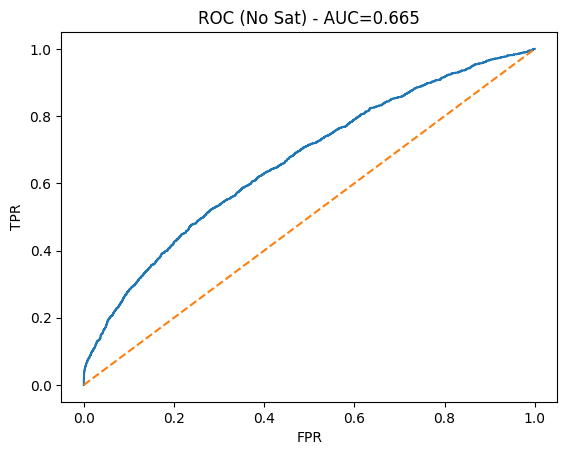

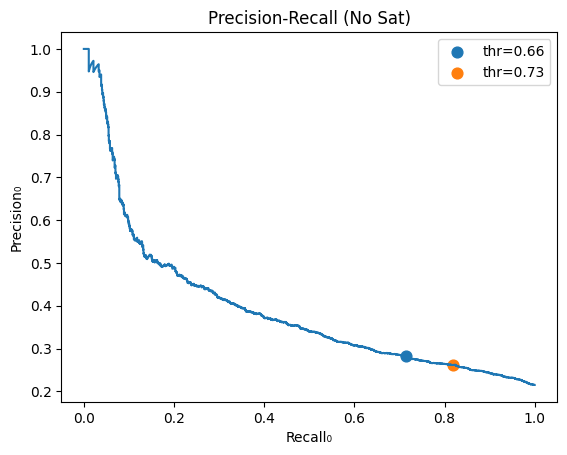

In [46]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
#import matplotlib.pyplot as plt, numpy as np

y0 = (y_test_ts==0).astype(int)          # clase positiva = No Sat
score0 = 1 - y_proba_ts                  # prob(No Sat)

# ROC
fpr, tpr, _ = roc_curve(y0, score0)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
plt.title(f"ROC (No Sat) - AUC={roc_auc:.3f}"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

# Precision-Recall
prec, rec, thr = precision_recall_curve(y0, score0)
plt.plot(rec, prec); plt.title("Precision-Recall (No Sat)")
plt.xlabel("Recall₀"); plt.ylabel("Precision₀")
# marca tus umbrales (pSat→pNoSat = 1-umbral)
for t in [0.66, 0.73]:
    t0 = 1 - t
    j = np.argmin(np.abs(thr - t0))
    plt.scatter(rec[j], prec[j], label=f"thr={t}", s=60)
plt.legend(); plt.show()


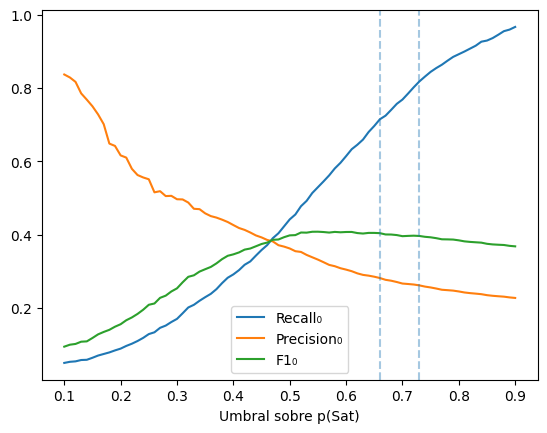

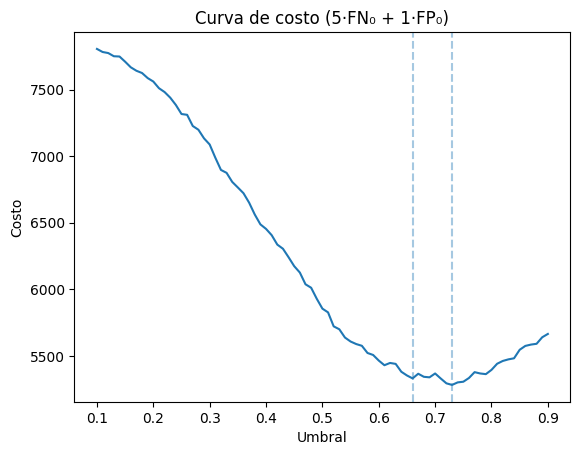

In [47]:
#from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
thr_grid = np.linspace(0.1,0.9,81)
rec0, prec0, f10, cost = [], [], [], []
for th in thr_grid:
    y_hat = (y_proba_ts >= th).astype(int)     # 1=Sat, 0=No Sat
    y_true0 = (y_test_ts==0).astype(int); y_hat0=(y_hat==0).astype(int)
    rec0.append(recall_score(y_true0, y_hat0))
    prec0.append(precision_score(y_true0, y_hat0, zero_division=0))
    f10.append(f1_score(y_true0, y_hat0))
    tn, fp, fn, tp = confusion_matrix(y_true0, y_hat0).ravel()
    cost.append(5*fn + fp)                     # cambia 5 si querés otro costo

plt.plot(thr_grid, rec0, label="Recall₀"); plt.plot(thr_grid, prec0, label="Precision₀"); plt.plot(thr_grid, f10, label="F1₀")
for t in [0.66,0.73]: plt.axvline(t, ls='--', alpha=.4)
plt.xlabel("Umbral sobre p(Sat)"); plt.legend(); plt.show()

plt.plot(thr_grid, cost);
for t in [0.66,0.73]: plt.axvline(t, ls='--', alpha=.4)
plt.title("Curva de costo (5·FN₀ + 1·FP₀)"); plt.xlabel("Umbral"); plt.ylabel("Costo"); plt.show()


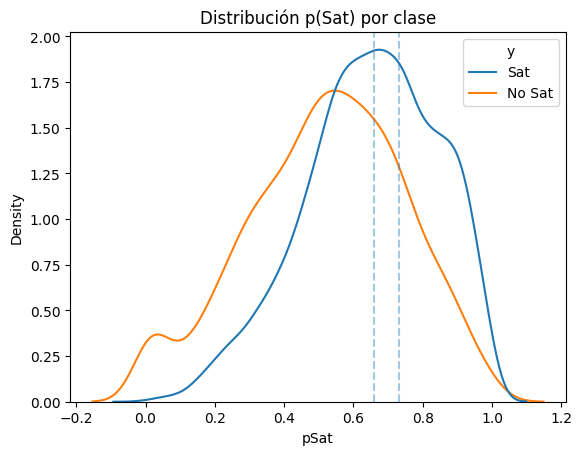

In [48]:
#import seaborn as sns, pandas as pd
dfp = pd.DataFrame({"pSat": y_proba_ts, "y": y_test_ts.map({0:"No Sat",1:"Sat"})})
sns.kdeplot(data=dfp, x="pSat", hue="y", common_norm=False);
for t in [0.66,0.73]: plt.axvline(t, ls='--', alpha=.4)
plt.title("Distribución p(Sat) por clase"); plt.show()


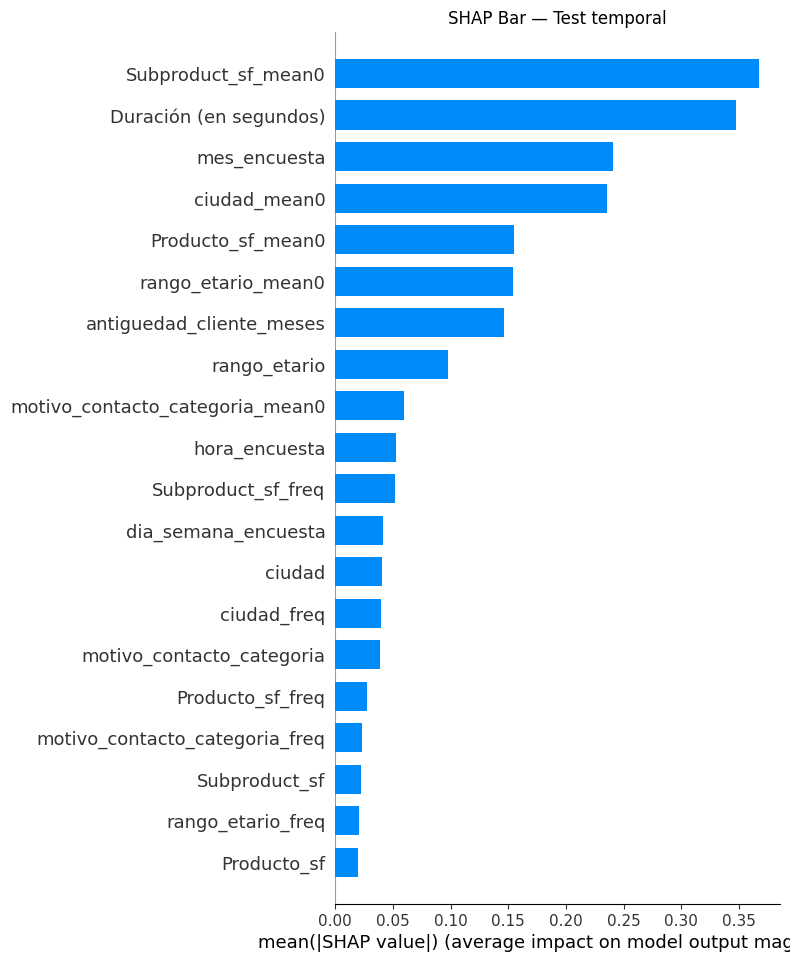

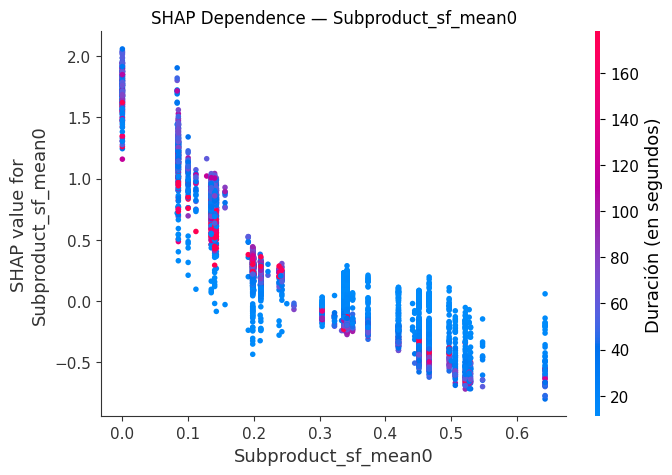

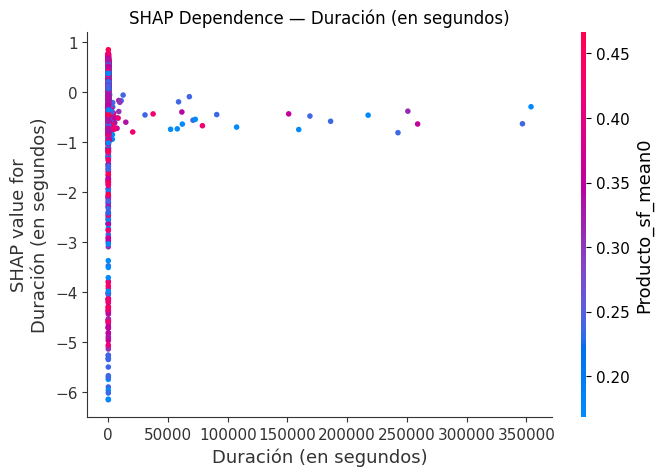

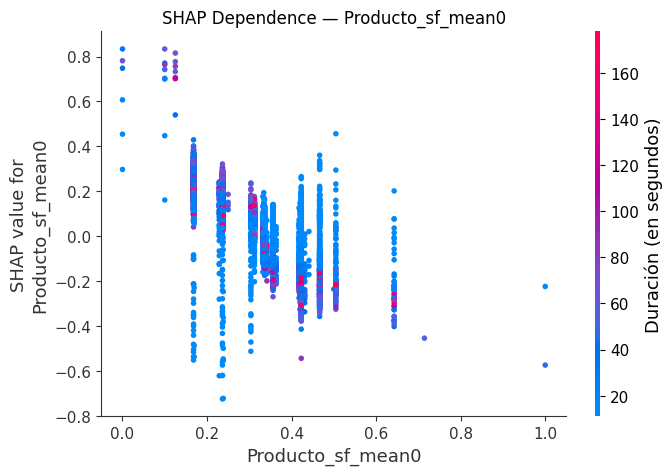

In [49]:
# summary tipo barra (importancia media |SHAP|)
shap.summary_plot(shap_values, X_te_ext, plot_type="bar", show=False)
plt.title("SHAP Bar — Test temporal"); plt.show()

# dependence plots (relación de 1 variable con el output)
for feat in ["Subproduct_sf_mean0","Duración (en segundos)","Producto_sf_mean0"]:
    shap.dependence_plot(feat, shap_values, X_te_ext, show=False)
    plt.title(f"SHAP Dependence — {feat}"); plt.show()


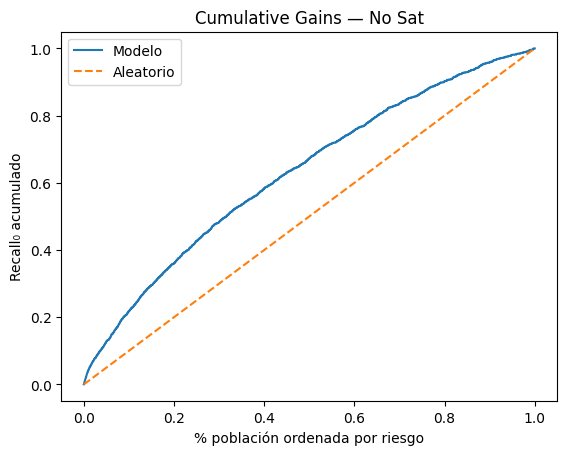

In [50]:
y0 = (y_test_ts==0).astype(int)
score0 = 1 - y_proba_ts
order = np.argsort(-score0)              # mayor riesgo primero
y0_sorted = y0.iloc[order].to_numpy()

cum_pos = np.cumsum(y0_sorted)
total_pos = y0.sum()
pct_pobl = np.arange(1, len(y0_sorted)+1)/len(y0_sorted)
rec_cum  = cum_pos/total_pos

plt.plot(pct_pobl, rec_cum, label="Modelo")
plt.plot(pct_pobl, pct_pobl, '--', label="Aleatorio")
plt.xlabel("% población ordenada por riesgo"); plt.ylabel("Recall₀ acumulado")
plt.title("Cumulative Gains — No Sat"); plt.legend(); plt.show()
